## Prepare Data

In [127]:
import math
import torch
from matplotlib import pyplot as plt
%matplotlib inline

import os
import pandas as pd
from pandas import factorize
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from scipy import stats

In [236]:
import re
os.chdir('/Users/chenya68/Documents/GitHub/BFO')
df_x = pd.read_excel('data/harpoon-doe.xlsx',sheet_name = 0, usecols = [1,2,3,4])
df_x.columns = [re.sub('[^A-Za-z0-9Δ]+', '_', element) for element in df_x.columns]
print(len(df_x))
df_x.head()

24


,Buffer_Type,pH,Sugar_Salt,Additive
0,Ace,4.5,4% Sorbitol,Arginine
1,Ace,4.5,4% Sorbitol,Glycine
2,Ace,5.0,4% Sorbitol,Arginine
3,Ace,5.0,4% Sorbitol,Glycine
4,Ace,5.0,0.1M NaCl,Glycine


In [237]:
df_y_1 = pd.read_excel('data/harpoon-doe.xlsx',sheet_name = 1, usecols = [1,4,7],skiprows = lambda x: x in [1])
df_y_1.columns = [re.sub('[^A-Za-z0-9Δ]+', '_', element) for element in df_y_1.columns]
print(len(df_y_1))
print(df_y_1.head())

df_y_2 = pd.read_excel('data/harpoon-doe.xlsx',sheet_name = 1, usecols = [2,5,8],skiprows = lambda x: x in [1])
df_y_2.columns = df_y_1.columns
print(len(df_y_2))
print(df_y_2.head())

df_y_3 = pd.read_excel('data/harpoon-doe.xlsx',sheet_name = 1, usecols = [3,6,9],skiprows = lambda x: x in [1])
df_y_3.columns = df_y_1.columns
print(len(df_y_3))
print(df_y_3.head())

24
   _Dimer_HMW_  _Monomer  _LMW
0          2.4      95.1   2.5
1          0.8      97.3   2.0
2          3.2      94.3   2.6
3          1.4      96.7   1.9
4          4.2      93.3   2.5
24
   _Dimer_HMW_  _Monomer  _LMW
0          1.6      96.2   2.2
1          1.1      96.6   2.2
2          2.0      95.6   2.4
3          1.4      96.4   2.3
4          2.3      95.2   2.4
24
   _Dimer_HMW_  _Monomer  _LMW
0          1.8      93.8   4.4
1          0.7      95.1   4.2
2          2.7      93.4   3.9
3          1.3      95.0   3.6
4          3.4      92.7   4.0


In [238]:
cols_feature01 = list(df_x.columns)
cols_target = list(df_y_1.columns)[0:2]
#cols_target = ['UP_SEC_HMW','UP_SEC_LMW']
cols_cate = ['Buffer_Type',
 'Sugar_Salt',
 'Additive']

In [239]:
total_df_y_long = pd.concat((df_y_1[cols_target],df_y_2[cols_target],df_y_3[cols_target]),axis = 0)
total_df_y_long.reset_index(inplace = True, drop = True)
total_df_y_long

,_Dimer_HMW_,_Monomer
0,2.4,95.1
1,0.8,97.3
2,3.2,94.3
3,1.4,96.7
4,4.2,93.3
...,...,...
67,3.3,92.3
68,3.7,92.3
69,3.6,92.2
70,4.2,90.8


In [240]:
df_y_1.columns = [c+'_1' for c in df_y_1.columns]
df_y_2.columns = [c+'_2' for c in df_y_2.columns]
df_y_3.columns = [c+'_3' for c in df_y_3.columns]

In [241]:
total_df_y = pd.concat((df_y_1[['_Dimer_HMW__1','_Monomer_1']],
                        df_y_2[['_Dimer_HMW__2','_Monomer_2']],
                        df_y_3[['_Dimer_HMW__3','_Monomer_3']]),axis = 1)

#convert categorical columns to labels
for x_name in cols_cate:
    labels, categories = factorize(df_x[x_name])
    df_x[x_name+"_label"] = labels
df_x.drop(cols_cate,axis = 1,inplace = True)
display(total_df_y.head())
display(df_x.head())

,_Dimer_HMW__1,_Monomer_1,_Dimer_HMW__2,_Monomer_2,_Dimer_HMW__3,_Monomer_3
0,2.4,95.1,1.6,96.2,1.8,93.8
1,0.8,97.3,1.1,96.6,0.7,95.1
2,3.2,94.3,2.0,95.6,2.7,93.4
3,1.4,96.7,1.4,96.4,1.3,95.0
4,4.2,93.3,2.3,95.2,3.4,92.7


,pH,Buffer_Type_label,Sugar_Salt_label,Additive_label
0,4.5,0,0,0
1,4.5,0,0,1
2,5.0,0,0,0
3,5.0,0,0,1
4,5.0,0,1,1


In [242]:
df_X_train, df_X_test, df_y_train, df_y_test = train_test_split(df_x, total_df_y, test_size=0.2, random_state=0)

In [168]:
from sklearn.compose import ColumnTransformer
xct = ColumnTransformer([('x_mm_scaler',MinMaxScaler(),
                          df_X_train.columns.difference(['Buffer_Type_label','Sugar_Salt_label','Additive_label']))], 
                         remainder = 'passthrough')

scaled_X_train=xct.fit_transform(df_X_train) 
scaled_X_test=xct.transform(df_X_test)

t_train_x = torch.Tensor(scaled_X_train)
t_test_x = torch.Tensor(scaled_X_test)

In [155]:
qual_ind_lev = {1: 4, 2:2, 3:2}



In [169]:
y_scale_label = 'y-stand'
if y_scale_label == 'y-robust':
    y_scaler = RobustScaler()
    scaled_y_train = y_scaler.fit_transform(df_y_train)
    #scaled_y_test= y_scaler.transform(df_y_test)
elif y_scale_label == 'y-stand':
    y_scaler = StandardScaler()
    scaled_y_train = y_scaler.fit_transform(df_y_train)
    #scaled_y_test= y_scaler.transform(df_y_test)
elif y_scale_label == 'y-minmax':
    y_scaler = MinMaxScaler()
    scaled_y_train = y_scaler.fit_transform(df_y_train)
    #scaled_y_test= y_scaler.transform(df_y_test)
else:
    scaled_y_train = df_y_train.to_numpy()
    #scaled_y_test = df_y_test.to_numpy()

t_train_y = torch.Tensor(scaled_y_train)

## Define GP

In [174]:
# Copyright © 2023, University of California, Irvine.
#
# GP_Plus is a proprietary software of the University of California, Irvine. This software
# is available for use free of charge for educational and research purposes by non-profit
# institutions and US government agencies. Other organizations are permitted to use 
# GP_Plus solely for evaluation purposes. Any further utilization requires explicit, prior
# written consent. Sale or unauthorized redistribution of this software is strictly 
# prohibited. Users may create copies for personal use, provided that these copies are 
# not sold or distributed and are subject to the same terms and conditions as outlined 
# herein.
#
# This software is provided as research software. As such, it is made available "as is" 
# without any warranty of any kind, either express or implied. By downloading or using 
# any part of this software, the user implicitly agrees to these terms. Please note that
# these terms and conditions are subject to modification at any time without prior notice.

import torch
import gpytorch
import math
from gpytorch.models import ExactGP
from gpytorch import settings as gptsettings
from gpytorch.priors import NormalPrior,LogNormalPrior
from gpytorch.constraints import GreaterThan,Positive
from gpytorch.distributions import MultivariateNormal,MultitaskMultivariateNormal
from gpplus import kernels
from gpplus.priors import LogHalfHorseshoePrior,MollifiedUniformPrior
from gpplus.utils.transforms import softplus,inv_softplus
from typing import List,Tuple,Union
from gpplus.likelihoods_noise.multifidelity import Multifidelity_likelihood
from botorch.models.utils import gpt_posterior_settings
from botorch.posteriors.gpytorch import GPyTorchPosterior
from botorch.models.gpytorch import BatchedMultiOutputGPyTorchModel, GPyTorchModel
from botorch import settings
from botorch.models.utils import fantasize as fantasize_flag, validate_input_scaling
from botorch.sampling.samplers import MCSampler
from torch import Tensor
from typing import Any, Dict, List, Optional, Union


class MultitaskGPModel(ExactGP, GPyTorchModel):
    def __init__(
        self,
        train_x:torch.Tensor,
        train_y:torch.Tensor,
        correlation_kernel,
        noise_indices:List[int],
        fix_noise:bool=False,
        lb_noise:float=1e-4,
        task_rank:int=None,
    ) -> None:
        # check inputs
        if not torch.is_tensor(train_x):
            raise RuntimeError("'train_x' must be a tensor")
        if not torch.is_tensor(train_y):
            raise RuntimeError("'train_y' must be a tensor")

        if train_x.shape[0] != train_y.shape[0]:
            raise RuntimeError("Inputs and output have different number of observations")
        
        self._num_tasks = train_y.shape[1]
        self._task_rank = task_rank if task_rank is not None else self._num_tasks

        # initializing likelihood
        #noise_constraint=GreaterThan(lb_noise,transform=torch.exp,inv_transform=torch.log)
        
    
        #likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=self._num_tasks,
        #                                                                  noise_constraint=noise_constraint)
        
        likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=self._num_tasks)

        """
        y_mean= train_y.min(dim = 0).values
        y_std=train_y.max(dim = 0).values-train_y.min(dim = 0).values
        train_y_sc = (train_y-y_mean)/y_std

        super(MultitaskGPModel, self).__init__(train_x, train_y_sc,likelihood)

        # registering mean and std of the raw response
        self.register_buffer('y_mean',y_mean)
        self.register_buffer('y_std',y_std)
        self.register_buffer('y_scaled',train_y_sc)
        """
        super(MultitaskGPModel, self).__init__(train_x, train_y,likelihood)
        
        
        

        # initializing and fixing noise
        """
        if lb_noise is not None:
            self.likelihood.initialize(noise=lb_noise)
        """
        
        self.likelihood.register_prior('raw_task_noises_prior',LogHalfHorseshoePrior(0.01,lb_noise),'raw_task_noises')
        self.likelihood.register_prior('raw_noise_prior',LogHalfHorseshoePrior(0.01,lb_noise),'raw_noise')

        if fix_noise:
            self.likelihood.raw_noise.requires_grad_(False)
            self.likelihood.noise_covar.noise =torch.tensor(4.9901e-05)
        
        #define prior for mean module
        mean_list = [gpytorch.means.ConstantMean(NormalPrior(0,1)) for t in range(self._num_tasks)]
        self.mean_module = gpytorch.means.MultitaskMean(
            mean_list, num_tasks=self._num_tasks
        )

        
        if isinstance(correlation_kernel,str):
            try:
                correlation_kernel_class = getattr(kernels,correlation_kernel)
                correlation_kernel = correlation_kernel_class(
                    ard_num_dims = self.train_inputs[0].size(1),
                    lengthscale_constraint=Positive(transform=torch.exp,inv_transform=torch.log),
                )
                
                correlation_kernel.register_prior(
                    'lengthscale_prior',MollifiedUniformPrior(math.log(0.1),math.log(10)),'raw_lengthscale'
                )
                
            except:
                raise RuntimeError(
                    "%s not an allowed kernel" % correlation_kernel
                )
        
        elif not isinstance(correlation_kernel,gpytorch.kernels.Kernel):
            raise RuntimeError(
                "specified correlation kernel is not a `gpytorch.kernels.Kernel` instance"
            )
        
        
        
        
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            correlation_kernel, num_tasks=self._num_tasks, rank=1)
        
        self.covar_module.task_covar_module.register_prior("covar_factor_prior",NormalPrior(0.,1),lambda m: m._parameters['covar_factor'])
        self.covar_module.task_covar_module.register_prior("raw_var_prior",NormalPrior(0.,1),lambda m: m._parameters['raw_var'])

        #self.task_covar_module = gpytorch.kernels.IndexKernel(num_tasks=self._num_tasks, rank = 1)
        #'covar_module.task_covar_module.covar_factor'
        #covar_module.task_covar_module._parameters['covar_factor']

    def forward(self,x:torch.Tensor):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x,covar_x)
    
    def predict(
        self,x:torch.Tensor,return_std:bool=False,include_noise:bool=False
    ):

        self.eval()
        self.likelihood.eval()
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            pred_res = self.likelihood(self.forward(x))   
            mean = pred_res.mean
            lower, upper = pred_res.confidence_region()
        return mean, lower, upper

## likelihood and optimization

In [175]:
# Copyright © 2023, University of California, Irvine.
# 
# GP+ Intellectual Property Notice:
# 
# The software known as GP+ is the proprietary material of the University of California, Irvine. 
# Non-profit academic institutions and U.S. government agencies may utilize this software exclusively for educational and research endeavors. 
# All other entities are granted permission for evaluation purposes solely; any additional utilization demands prior written consent from the appropriate authority. 
# The direct sale or redistribution of this software, in any form, without explicit written authorization is strictly prohibited. 
# Users are permitted to make duplicate copies of the software, contingent upon the assurance that no copies are sold or redistributed and they adhere to the stipulated terms herein.
# 
# Being academic research software, GP+ is provided on an "as is" basis, devoid of warranties, whether explicit or implicit. 
# The act of downloading or executing any segment of this software inherently signifies compliance with these terms. 
# The University of California, Irvine reserves the right to modify these terms and conditions without prior intimation at any juncture.

import torch
import numpy as np
from gpytorch import settings as gptsettings
from gpytorch.utils.errors import NanError,NotPSDError
from scipy.optimize import minimize,OptimizeResult
from collections import OrderedDict
from functools import reduce
from joblib import Parallel,delayed
from joblib.externals.loky import set_loky_pickler
from typing import Dict,List,Tuple,Optional,Union
from copy import deepcopy
from scipy.optimize import Bounds
from scipy.optimize import NonlinearConstraint
from scipy.optimize import BFGS
#######################################################

from gpplus.utils.interval_score import interval_score
tkwargs = {
    "dtype": torch.float,
    "device": torch.device("cpu" if torch.cuda.is_available() else "cpu"),
}

def marginal_log_likelihood(model,add_prior:bool,regularization_parameter=[0,0]):
    output = model(*model.train_inputs)
    out = model.likelihood(output).log_prob(model.train_targets)
    if add_prior:
        # add priors
        for _, module, prior, closure, _ in model.named_priors():
            out.add_(prior.log_prob(closure(module)).sum())
    temp = 0
    temp_1=0
    for name, param in model.named_parameters():
        string_list = ['fci', 'h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'h8','h9', 'h10', 'h11', 'h12','fce']
        if name in string_list:
            temp += torch.norm(param)
            temp_1 += torch.sum(torch.abs(param))
        elif name in ['nn_model.' + str + '.bias' for str in string_list]:
            temp += torch.norm(param)
            temp_1 += torch.sum(torch.abs(param))

    out -= regularization_parameter[0]*temp_1 + regularization_parameter[1]* temp    
    ## Interval Score if neede for BO
    if model.IS is True:
        score, accuracy = interval_score(output.mean + 1.96 * output.variance.sqrt(), output.mean - 1.96 * output.variance.sqrt(), model.y_scaled)
        return out - 0.08*torch.abs(out) * score#- torch.exp(model.interval_alpha) * score
    return out 


class MLLObjective:

    def __init__(self,model,add_prior,regularization_parameter):
        self.model = model 
        self.add_prior = add_prior
        self.regularization_parameter=regularization_parameter

        parameters = OrderedDict([
            (n,p) for n,p in self.model.named_parameters() if p.requires_grad
        ])
        self.param_shapes = OrderedDict()
        for n,p in self.model.named_parameters():
            if p.requires_grad:
                if len(parameters[n].size()) > 0:
                    self.param_shapes[n] = parameters[n].size()
                else:
                    self.param_shapes[n] = torch.Size([1])
    
    def pack_parameters(self) -> np.ndarray:
        parameters = OrderedDict([
            (n,p) for n,p in self.model.named_parameters() if p.requires_grad
        ])
        
        return np.concatenate([parameters[n].cpu().data.numpy().ravel() for n in parameters])
    
    def unpack_parameters(self, x:np.ndarray) -> torch.Tensor:
        i = 0
        named_parameters = OrderedDict()
        for n in self.param_shapes:
            param_len = reduce(lambda x,y: x*y, self.param_shapes[n])
            # slice out a section of this length
            param = x[i:i+param_len]
            # reshape according to this size, and cast to torch
            param = param.reshape(*self.param_shapes[n])
            named_parameters[n] = torch.from_numpy(param).to(**tkwargs)
            # update index
            i += param_len
        return named_parameters

    def pack_grads(self) -> None:
        """Concatenate gradients from the parameters to 1D numpy array
        """
        grads = []
        for name,p in self.model.named_parameters():
            if p.requires_grad:
                grad = p.grad.cpu().data.numpy()
                grads.append(grad.ravel())
        return np.concatenate(grads).astype(np.float64)

    def fun(self, x:np.ndarray,return_grad=True) -> Union[float,Tuple[float,np.ndarray]]:
        # unpack x and load into module 
        state_dict = self.unpack_parameters(x)
        old_dict = self.model.state_dict()
        old_dict.update(state_dict)
        self.model.load_state_dict(old_dict)

        self.model.zero_grad()
        obj = -marginal_log_likelihood(self.model, self.add_prior,self.regularization_parameter) # negative sign to minimize
        
        if return_grad:
            obj.backward()
            
            return obj.item(),self.pack_grads()
        
        return obj.item()


def _sample_from_prior(model) -> np.ndarray:
    out = []
    for _,module,prior,closure,_ in model.named_priors():
        if not closure(module).requires_grad:
            continue
            
        out.append(prior.expand(closure(module).shape).sample().cpu().numpy().ravel())
    
    return np.concatenate(out)


def cons_f(x,likobj):
    zeta = torch.tensor(likobj.model.zeta, dtype = torch.float64)
    A = likobj.unpack_parameters(x)['fci']
    likobj.model.nn_model.fci.weight.data = A
    positions = likobj.model.nn_model(zeta)
    out_constraint=positions.detach().numpy().reshape(-1,)
    return out_constraint[0:8]


def get_bounds(likobj, theta):

    dic = likobj.unpack_parameters(theta)

    minn = np.empty(0)
    maxx = np.empty(0)
    for name, values in dic.items():
        for ii in range(len(likobj.model.qual_kernel_columns)):
            if name ==  str(likobj.model.qual_kernel_columns[ii]):
                minn = np.concatenate( (minn,  np.repeat(-3, values.numel()) ) )
                maxx = np.concatenate( (maxx,  np.repeat(3, values.numel()) ) )
        #if name == 'likelihood.noise_covar.raw_noise' or name.startswith('[') or name.startswith('latent['):
        if name.startswith ('likelihood.raw_') or name.startswith('[') or name.startswith('latent['):
            minn = np.concatenate( (minn,  np.repeat(-np.inf, values.numel()) ) )
            maxx = np.concatenate( (maxx,  np.repeat( np.inf, values.numel()) ) )
        if 'raw_lengthscale' in name:
            minn = np.concatenate( (minn,  np.repeat(-10.0, values.numel()) ) )
            maxx = np.concatenate( (maxx,  np.repeat( 3.0, values.numel()) ) )
        #elif name.startswith('covar_module'):
        elif 'task_covar_module' in name:
            minn = np.concatenate( (minn,  np.repeat(-10.0, values.numel()) ) )
            maxx = np.concatenate( (maxx,  np.repeat( 3.0, values.numel()) ) )
            ######################################################################################### For multiple Bases ##################################
        elif name.startswith('mean'):
            minn = np.concatenate( (minn,  np.repeat(-1.5, values.numel()) ) )
            maxx = np.concatenate( (maxx,  np.repeat( 1.5, values.numel()) ) )
        elif name.startswith('Theta_'):
            minn = np.concatenate( (minn,  np.repeat(-15, values.numel()) ) )
            maxx = np.concatenate( (maxx,  np.repeat( 15, values.numel()) ) )
        elif name.startswith('encoder'):
            minn = np.concatenate( (minn,  np.repeat(-15, values.numel()) ) )
            maxx = np.concatenate( (maxx,  np.repeat( 15, values.numel()) ) )
            ######################################################################################### For A_matrix and Variationa encoder  #################
        elif name.startswith('A_matrix'):
            minn = np.concatenate( (minn,  np.repeat(-10, values.numel()) ) )
            maxx = np.concatenate( (maxx,  np.repeat( 10, values.numel()) ) )
    return np.array(minn).reshape(-1,), np.array(maxx).reshape(-1,)


def _fit_model_from_state(likobj,theta0,jac,options, method = 'trust-constr',constraint=False,bounds=False):
    
    min, max = get_bounds(likobj, theta0)
    bounds_acts = Bounds(min, max)
    nonlinear_constraint = NonlinearConstraint(lambda x: cons_f(x, likobj), [0,0,0,0,-5,0,-5,-5],[0,0,5,0,5,5,5,5], jac='2-point', hess=BFGS())
    '''
    if constraint==True:
        nonlinear_constraint = NonlinearConstraint(lambda x: cons_f(x, likobj), [0,0,0,0,-inf,0],[0,0,inf,0,inf,inf], jac='2-point', hess=BFGS())
    
    else:
        nonlinear_constraint = NonlinearConstraint(lambda x: cons_f(x, likobj), [-inf,-inf,-inf,-inf,-inf,-inf],[inf,inf,inf,inf,inf,inf], jac='2-point', hess=BFGS())

    '''
    eq_cons = {'type': 'eq',
                'fun' : lambda x: np.array([cons_f(x, likobj)[0],cons_f(x, likobj)[1],cons_f(x, likobj)[3]])}
    ineq_cons = {'type': 'ineq',
                'fun' : lambda x: np.array([cons_f(x, likobj)[2],cons_f(x, likobj)[5]])}
    if constraint==True:
        nonlinear_constraint=[nonlinear_constraint]
    else:
        nonlinear_constraint=[]


    if bounds==True:
        bounds=bounds_acts
    else:
        bounds=None


    try:
        with gptsettings.fast_computations(log_prob=False):
            return minimize(
                fun = likobj.fun,
                x0 = theta0,
                args=(True) if jac else (False),

                method = method,
                jac=jac,
                bounds=bounds,
                constraints= nonlinear_constraint,
                #constraints=[eq_cons, ineq_cons],
                options= options 
            )


    except Exception as e:
        if isinstance(e,NotPSDError) or isinstance(e, NanError):
            # Unstable hyperparameter configuration. This can happen if the 
            # initial starting point is bad. 
            return e
        else:
            # There is some other issue, most likely with the inputs supplied
            # by the user. Raise error to indicate the problematic part.
            raise


def fit_model_scipy(
    model,
    add_prior:bool=True,
    num_restarts:int=1,
    theta0_list:Optional[List[np.ndarray]]=None,
    jac:bool=True, 
    options:Dict={},
    n_jobs:int=-1,
    method = 'L-BFGS-B',
    constraint=False,
    bounds=False,
    regularization_parameter:List[int]=[0,0]
    ) -> Tuple[List[OptimizeResult],float]:

    defaults = {}

    if method == 'L-BFGS-B':
        defaults = {'ftol':1e-6,'gtol':1e-5,'maxfun':5000,'maxiter':2000}
    elif method == 'trust-constr':
        defaults = {'verbose': 1}
    elif method == 'BFGS':
        defaults = {'gtol': 1e-07, 'norm': np.inf, 'eps': 1.4901161193847656e-08,'maxiter': None, 'disp': False, 'return_all': False, 'finite_diff_rel_step': None}#
    elif method == 'SLSQP':
        defaults = { 'maxiter': 100, 'ftol': 1e-06, 'iprint': 1, 'disp': False, 'eps': 1.4901161193847656e-08, 'finite_diff_rel_step': None}#
    elif method == 'Newton-CG':
        defaults={'xtol': 1e-05, 'eps': 1.4901161193847656e-08, 'maxiter': None, 'disp': False, 'return_all': False}
    else:
        raise ValueError('Wrong method')

    if len(options) > 0:
        for key in options.keys():
            if key not in defaults.keys():
                raise RuntimeError('Unknown option %s!'%key)
            defaults[key] = options[key]

    likobj = MLLObjective(model,add_prior,regularization_parameter)

    if theta0_list is None:
        theta0_list = [likobj.pack_parameters()]
        if num_restarts > -1:
            theta0_list.extend([_sample_from_prior(model) for _ in range(num_restarts+1)])
            theta0_list.pop(0)                                                          
    
    set_loky_pickler("dill") 

    out = Parallel(n_jobs=n_jobs,verbose=0)(
        delayed(_fit_model_from_state)(likobj,theta0,jac,defaults, method,constraint,bounds) \
            for theta0 in theta0_list
    )
    #out = [_fit_model_from_state(likobj,theta0,jac,defaults,method,constraint,bounds) for theta0 in theta0_list]
    set_loky_pickler("pickle")

    nlls_opt = [np.inf if isinstance(res,Exception) else res.fun for res in out]
    best_idx = np.argmin(nlls_opt)
    try:
        theta_best = out[best_idx].x
        old_dict = deepcopy(model.state_dict())
        old_dict.update(likobj.unpack_parameters(theta_best))
        model.load_state_dict(old_dict)

        if 'fci' in [name for name,p in model.named_parameters()]:
            model.nn_model.fci.weight.data = old_dict['fci']       
    except:
        pass
    return out,nlls_opt[best_idx]

In [287]:
import torch
import math
import gpytorch
from typing import Dict,List,Optional
from gpytorch.constraints import Positive
from gpytorch.priors import NormalPrior
from gpytorch.distributions import MultivariateNormal, MultitaskMultivariateNormal
from gpplus.priors import MollifiedUniformPrior
from gpplus.visual.plot_latenth import plot_sep
from gpplus.models.gpregression import GPR
from gpplus import kernels
from gpplus.priors import MollifiedUniformPrior
import numpy as np
from gpplus.preprocessing import setlevels
import matplotlib.pyplot as plt
import torch
from gpytorch.means import Mean
import torch
from tabulate import tabulate
from gpplus.utils import set_seed
#from gpplus.optim import fit_model_scipy, noise_tune2, fit_model_torch

import numpy as np
import sobol_seq
import warnings
from torch import Tensor
from gpytorch.means import Mean
from torch.nn.parameter import Parameter
from torch.nn import init
from torch import nn
import torch.nn.functional as F 
from scipy.stats import norm

class GP_Plus(MultitaskGPModel):
    """The GP_Plus which extends GPs to learn nonlinear and probabilistic nmanifold, handle categorical inputs, and  ... ...

    :note: Binary categorical variables should not be treated as qualitative inputs. There is no 
        benefit from applying a latent variable treatment for such variables. Instead, treat them
        as numerical inputs.

    :param train_x: The training inputs (size N x d). Qualitative inputs needed to be encoded as 
        integers 0,...,L-1 where L is the number of levels. For best performance, scale the 
        numerical variables to the unit hypercube.
    """
    def __init__(
        self,
        train_x:torch.Tensor,
        train_y:torch.Tensor,
        quant_correlation_class:str='Rough_RBF',
        qual_ind_lev = {},
        multiple_noise = False,
        lv_dim:int=2,
        fix_noise:bool=False,
        fixed_length_scale:bool=False,
        fixed_omega=torch.tensor([1.0]),
        lb_noise:float=1e-4,
        NN_layers:list = [],
        encoding_type = 'one-hot',
        manifold_type='deterministic',
        uniform_encoding_columns = 2,
        lv_columns = [] ,
        base='single_constant',
        base_hf='zero',
        NN_layers_base=[],
        base_function_size=None,
        calibration_id=[],
        seed_number=1,
        mean_prior_cal=0,
        std_prior_cal=1,
        device="cpu",
        dtype= torch.float,
        IS=False
    ) -> None:
        
        self.IS=IS
        tkwargs = {}  # or dict()
        tkwargs['dtype'] = dtype
        tkwargs['device'] =torch.device(device)
        self.tkwargs=tkwargs


        self.mean_prior_cal=mean_prior_cal
        self.std_prior_cal=std_prior_cal
        if fixed_length_scale:
            self.fixed_omega=fixed_omega.to(**self.tkwargs)
        else:
            self.fixed_omega=None
            
        ## The checks lists:
        if not isinstance(train_x, torch.Tensor):
            original_type = type(train_x).__name__
            warnings.warn(f"'train_x' was not a torch.Tensor (type: {original_type}). It is converted to torch.Tensor to proceed with the emulation.")
            train_x = torch.tensor(train_x)

        if not isinstance(train_y, torch.Tensor):
            original_type = type(train_y).__name__
            warnings.warn(f"'train_y' was not a torch.Tensor (type: {original_type}). It is converted to torch.Tensor to proceed with the emulation.")
            train_y = torch.tensor(train_y)

        if not isinstance(qual_ind_lev, dict):
            raise ValueError("qual_ind_lev should be a dictionary")

        if multiple_noise not in [True, False]:
            raise ValueError("multiple_noise should be either True or False")

        if not isinstance(lv_dim, int):
            raise ValueError("lv_dim should be an integer")

        if quant_correlation_class not in ['Rough_RBF', 'RBFKernel', 'Matern32Kernel', 'Matern12Kernel','Matern52Kernel']:
            raise ValueError("quant_correlation_class should be 'Rough_RBF', 'RBFKernel', 'Matern32Kernel', 'Matern12Kernel','Matern52Kernel'")

        if fix_noise not in [True, False]:
            raise ValueError("fix_noise should be either True or False")

        if not isinstance(NN_layers, list) or not all(isinstance(i, int) for i in NN_layers):
            raise ValueError("NN_layers should be a list with integers representing the number of neurons in each layer for mapping the manifold")

        if encoding_type != 'one-hot':
            raise ValueError("encoding_type should be 'one-hot'")

        if manifold_type not in ['deterministic', 'probabilistic']:
            raise ValueError("manifold_type should be either 'deterministic' or 'probabilistic'")

        if not isinstance(lv_columns, list) or not all(isinstance(i, int) for i in lv_columns):
            raise ValueError("lv_columns should be a list with integers showing the number of categorical inputs to be considered in a separate manifold in each layer")

    
        supported_singl_functions = ['single_sin', 'single_cos', 'single_exp', 'single_log', 'single_tan', 'single_asin', 'single_acos', 'single_atan', 
                                    'single_sinh', 'single_cosh', 'single_tanh', 'single_asinh', 'single_acosh', 'single_atanh', 'single_sqrt', 
                                    'single_abs', 'single_ceil', 'single_floor', 'single_round']

        self.supported_singl_base_functions=supported_singl_functions
        
        supported_multi_base_functions=['single_zero', 'single_polynomial', 'single_constant', 'multiple_polynomial_2d', 'multiple_constant', 'neural_network']

        #if base not in supported_multi_base_functions and base not in supported_singl_functions:
        #     raise ValueError("base is not valied'")

        if not isinstance(NN_layers_base, list) or not all(isinstance(i, int) for i in NN_layers_base):
            raise ValueError("NN_layers_base should be a list with integers representing the number of neurons in each layer for the mean function")

        if not isinstance(calibration_id, list) or not all(isinstance(i, int) for i in calibration_id):
            raise ValueError("calibration_id should be a list where each entry shows the column number in the dataset that the calibration parameters are assigned to")
        
        train_x=self.fill_nan_with_mean(train_x,calibration_id)
        ###############################################################################################
        ###############################################################################################
        self.seed=seed_number
        self.calibration_id=calibration_id
        self.calibration_source_index=0    ## It is supposed the calibration parameter is for high fidelity needs
        qual_index = list(qual_ind_lev.keys())
        all_index = set(range(train_x.shape[-1]))
        quant_index = list(all_index.difference(qual_index))
        num_levels_per_var = list(qual_ind_lev.values())
        #------------------- lm columns --------------------------
        lm_columns = list(set(qual_index).difference(lv_columns))
        if len(lm_columns) > 0:
            qual_kernel_columns = [*lv_columns, lm_columns]
        else:
            qual_kernel_columns = lv_columns
        #########################
        if len(qual_index) > 0:
            train_x = torch.tensor(setlevels(train_x, qual_index=qual_index))#.to(**self.tkwargs)
        #
        train_x=train_x.to(**self.tkwargs)
        train_y=train_y.to(**self.tkwargs)
        #train_y=train_y.reshape(-1)#.to(**self.tkwargs)
        
        if multiple_noise:
            noise_indices = list(range(0,num_levels_per_var[-1]))
        else:
            noise_indices = []

        if len(qual_index) == 1 and num_levels_per_var[0] < 2:
            temp = quant_index.copy()
            temp.append(qual_index[0])
            quant_index = temp.copy()
            qual_index = []
            lv_dim = 0
        elif len(qual_index) == 0:
            lv_dim = 0

        quant_correlation_class_name = quant_correlation_class

        if len(qual_index) == 0:
            lv_dim = 0
        if quant_correlation_class_name == 'Rough_RBF':
            quant_correlation_class = 'RBFKernel'

        if quant_correlation_class_name == 'Matern32Kernel':
            quant_correlation_class = 'Matern32Kernel'
        
        if quant_correlation_class_name == 'Matern52Kernel':
            quant_correlation_class = 'Matern52Kernel'

        if quant_correlation_class_name == 'Matern12Kernel':
            quant_correlation_class = 'Matern12Kernel'

        if len(qual_index) > 0:
            ####################### Defined multiple kernels for seperate variables ###################
            qual_kernels = []
            for i in range(len(qual_kernel_columns)):
                qual_kernels.append(kernels.RBFKernel(
                    active_dims=torch.arange(lv_dim) + lv_dim * i) )
                qual_kernels[i].initialize(**{'lengthscale':1.0})
                qual_kernels[i].raw_lengthscale.requires_grad_(False)  

        if len(quant_index) == 0:
            print('---no numerical columns----')
            correlation_kernel = qual_kernels[0]
            for i in range(1, len(qual_kernels)):
                correlation_kernel *= qual_kernels[i]
        else:
            try:
                quant_correlation_class = getattr(kernels,quant_correlation_class)
            except:
                raise RuntimeError(
                    "%s not an allowed kernel" % quant_correlation_class
                )
            if quant_correlation_class_name == 'RBFKernel':
                quant_kernel = quant_correlation_class(
                    ard_num_dims=len(quant_index),
                    active_dims=len(qual_kernel_columns) * lv_dim+torch.arange(len(quant_index)),
                    lengthscale_constraint= Positive(transform= torch.exp,inv_transform= torch.log)
                )
            elif quant_correlation_class_name == 'Rough_RBF':
                quant_kernel = quant_correlation_class(
                    ard_num_dims=len(quant_index),
                    active_dims=len(qual_kernel_columns)*lv_dim+torch.arange(len(quant_index)),
                    lengthscale_constraint= Positive(transform= lambda x: 2.0**(-0.5) * torch.pow(10,-x/2),inv_transform= lambda x: -2.0*torch.log10(x/2.0))
                )
            elif quant_correlation_class_name == 'Matern12Kernel':
                quant_kernel = quant_correlation_class(
                    ard_num_dims=len(quant_index),
                    active_dims=len(qual_kernel_columns)*lv_dim+torch.arange(len(quant_index)),
                    lengthscale_constraint= Positive(transform= lambda x: 2.0**(-0.5) * torch.pow(10,-x/2),inv_transform= lambda x: -2.0*torch.log10(x/2.0))
                )
            
            elif quant_correlation_class_name == 'Matern32Kernel':
                quant_kernel = quant_correlation_class(
                    ard_num_dims=len(quant_index),
                    active_dims=len(qual_kernel_columns)*lv_dim+torch.arange(len(quant_index)),
                    #lengthscale_constraint= Positive(transform= torch.exp,inv_transform= torch.log)
                    lengthscale_constraint= Positive(transform= lambda x: 2.0**(-0.5) * torch.pow(10,-x/2),inv_transform= lambda x: -2.0*torch.log10(x/2.0))             
                )
            elif quant_correlation_class_name == 'Matern52Kernel':
                quant_kernel = quant_correlation_class(
                    ard_num_dims=len(quant_index),
                    active_dims=len(qual_kernel_columns)*lv_dim+torch.arange(len(quant_index)),
                    #lengthscale_constraint= Positive(transform= torch.exp,inv_transform= torch.log)  
                    lengthscale_constraint= Positive(transform= lambda x: 2.0**(-0.5) * torch.pow(10,-x/2),inv_transform= lambda x: -2.0*torch.log10(x/2.0))       
                )
                #####################
            
            if quant_correlation_class_name == 'RBFKernel':
                quant_kernel.register_prior(
                    'lengthscale_prior', MollifiedUniformPrior(math.log(0.1),math.log(10)),'raw_lengthscale'
                )
                
            elif quant_correlation_class_name == 'Rough_RBF':
                quant_kernel.register_prior(
                    'lengthscale_prior',NormalPrior(-3.0,3.0),'raw_lengthscale'
                )
            elif quant_correlation_class_name == 'Matern12Kernel':
                quant_kernel.register_prior(
                    #'lengthscale_prior', MollifiedUniformPrior(math.log(0.1),math.log(10)),'raw_lengthscale'
                    'lengthscale_prior',NormalPrior(-3.0,3.0),'raw_lengthscale'
                )

            elif quant_correlation_class_name == 'Matern32Kernel':
                quant_kernel.register_prior(
                    #'lengthscale_prior', MollifiedUniformPrior(math.log(0.1),math.log(10)),'raw_lengthscale'
                    'lengthscale_prior',NormalPrior(-3.0,3.0),'raw_lengthscale'
                )

            elif quant_correlation_class_name == 'Matern52Kernel':
                quant_kernel.register_prior(
                    #'lengthscale_prior', MollifiedUniformPrior(math.log(0.1),math.log(10)),'raw_lengthscale'
                    'lengthscale_prior',NormalPrior(-3.0,3.0),'raw_lengthscale'
                )
            
            #########Product between qual kernels and quant kernels############
            if len(qual_index) > 0:
                temp = qual_kernels[0]
                for i in range(1, len(qual_kernels)):
                    temp *= qual_kernels[i]
                correlation_kernel = temp*quant_kernel #+ qual_kernel + quant_kernel
            else:
                correlation_kernel = quant_kernel
            
        
        super(GP_Plus,self).__init__(
            train_x=train_x,train_y=train_y,noise_indices=noise_indices,
            correlation_kernel=correlation_kernel,
            fix_noise=fix_noise,lb_noise=lb_noise
        )
        
        # register index and transforms
        self.register_buffer('quant_index',torch.tensor(quant_index))
        self.register_buffer('qual_index',torch.tensor(qual_index))

        self.quant_kernel = quant_kernel
        self.correlation_kernel = correlation_kernel
        self.qual_kernels = qual_kernels
        
        self.qual_kernel_columns = qual_kernel_columns
        # latent variable mapping
        self.num_levels_per_var = num_levels_per_var
        self.lv_dim = lv_dim
        self.uniform_encoding_columns = uniform_encoding_columns
        self.encoding_type = encoding_type
        self.manifold_type=manifold_type
        self.perm =[]
        self.zeta = []
        self.random_zeta=[]
        self.perm_dict = []
        self.A_matrix = []
        self.epsilon=None
        self.epsilon_f=None
        self.embeddings_Dtrain=[]
        self.count=train_x.size()[0]
        if len(qual_kernel_columns) > 0:
            for i in range(len(qual_kernel_columns)):
                if type(qual_kernel_columns[i]) == int:
                    num = self.num_levels_per_var[qual_index.index(qual_kernel_columns[i])]
                    cat = [num]
                else:
                    cat = [self.num_levels_per_var[qual_index.index(k)] for k in qual_kernel_columns[i]]
                    num = sum(cat)

                zeta, perm, perm_dict = self.zeta_matrix(num_levels=cat, lv_dim = self.lv_dim)
                self.zeta.append(zeta)
                self.perm.append(perm)
                self.perm_dict.append(perm_dict)       
                ###################################  latent map (manifold) #################################   
                if self.manifold_type=='probabilistic':
                    setattr(self,'A_matrix', Variational_Encoder(self, input_size= num, num_classes=5, 
                        layers =NN_layers, name = str(qual_kernel_columns[i])).to(**tkwargs))
                else:
                    model_temp = FFNN(self, input_size= num, num_classes=lv_dim, 
                        layers = NN_layers, name ='latent'+ str(qual_kernel_columns[i])).to(**self.tkwargs)
                    #model_temp = FFNN(self, input_size= num, num_classes=lv_dim, 
                    #    layers = NN_layers, name ='A_matrix').to(**self.tkwargs)
                    self.A_matrix.append(model_temp)

        ##################################################################################
        if fixed_length_scale == True:
            self.covar_module.base_kernel.raw_lengthscale.data = self.fixed_omega #torch.tensor([self.omega, self.omega])  # Set the desired value
            self.covar_module.base_kernel.raw_lengthscale.requires_grad = False  # Fix the hyperparameter
        ###################################  Mean Function #################################   
        i=0
        self.base=base
        self.base_hf=base_hf
        self.num_sources=int(torch.max(train_x[:,-1]))
        size=train_x.shape[1]
        if self.base.startswith('single'):
            self.single_base_register(size,base_type=self.base,wm='mean_module')
        elif self.base.startswith('multi'):
            self.multi_base_register(train_x,supported_multi_base_functions,self.base_hf)
        elif self.base=='neural_network': ###### One NN for ALL 
            setattr(self,'mean_module_NN_All', FFNN_as_Mean(self, input_size= train_x.shape[1]+2*len(qual_index)-len(qual_index), num_classes=1,layers =NN_layers_base, name = str('mean_module_'+str(i)+'_')).to(**tkwargs)) 
        else: 
            raise ValueError('The "base" argument must start with "multi", "single", or "neural_network".')



    def forward(self,x:torch.Tensor):
        if self.manifold_type=='probabilistic':
            set_seed(self.seed)
            if self.training:
                Numper_of_pass=5 #20
            else:
                Numper_of_pass=10 #30
        else:
            Numper_of_pass=1
        
        size_sigma_sum = x.size(0)*self._num_tasks
        Sigma_sum=torch.zeros(size_sigma_sum,size_sigma_sum, dtype=torch.float64).to(self.tkwargs['device'])
        #mean_x_sum=torch.zeros(x.size(0), dtype=torch.float64).to(self.tkwargs['device'])
        mean_x_sum=torch.zeros(x.size(0),self._num_tasks, dtype=torch.float64).to(self.tkwargs['device'])
        #print('mean_x_sum.shape',mean_x_sum.shape)

        for NP in range(Numper_of_pass):
            x_forward_raw=x.clone()
            nd_flag = 0
            if x.dim() > 2:
                xsize = x.shape
                x = x.reshape(-1, x.shape[-1])
                nd_flag = 1
            
            x_new= x
            if len(self.qual_kernel_columns) > 0:
                embeddings = []
                for i in range(len(self.qual_kernel_columns)):
                    temp= self.transform_categorical(x=x[:,self.qual_kernel_columns[i]].clone().type(torch.int64).to(self.tkwargs['device']), 
                        perm_dict = self.perm_dict[i], zeta = self.zeta[i])
                dimm=x_forward_raw.size()[0]
                if self.manifold_type=='probabilistic': 
                    # Convert to list of tuples
                    x_raw=torch.zeros(temp.size(0),2)
                    # Find unique rows
                    unique_rows, indices = torch.unique(temp, dim=0, return_inverse=True)
                    temp= unique_rows
                    dimm=unique_rows.size()[0]
                    if self.training:
                        epsilon=torch.normal(mean=0,std=1,size=[dimm,2])## use np instead of torch 
                        embeddings.append(getattr(self,'A_matrix')(x=temp.float().to(**self.tkwargs),epsilon=epsilon))
                    else:
                        if x.size()[0]==self.count:
                            epsilon=torch.normal(mean=0,std=1,size=[dimm,2])
                            embeddings.append(getattr(self,'A_matrix')(x=temp.float().to(**self.tkwargs),epsilon=epsilon))
                            self.embeddings_Dtrain.append(embeddings[0])
                        else:
                            embeddings.append(self.embeddings_Dtrain[NP])
                    for i, index in enumerate(indices):
                        x_raw[i] = embeddings[0][index]
                    embeddings=x_raw
                    x_new= torch.cat([embeddings,x[...,self.quant_index.long()]],dim=-1)
                else:
                    embeddings.append(self.A_matrix[i](temp.float().to(**self.tkwargs)))
                    x_new= torch.cat([embeddings[0],x[...,self.quant_index.long()].to(**self.tkwargs)],dim=-1)
                #print('x_new.shape',x_new.shape)
            if nd_flag == 1:
                x_new = x_new.reshape(*xsize[:-1], -1)
            
        #################### Multiple baises (General Case) ####################################  
            if self.base.startswith('multi'):
                mean_x = self.multi_mean(x_new,x_forward_raw).to(**self.tkwargs) 
            elif self.base.startswith('neural_network'):
                mean_x = getattr(self, 'mean_module_NN_All')(x_new.clone().detach()).reshape(-1)
            else:
                #mean_x = self.single_mean(x_new).to(**self.tkwargs)
                mean_x = self.mean_module(x_new).to(**self.tkwargs)
            #print('mean_x.shape',mean_x.shape)
            covar_x = self.covar_module(x_new).to(**self.tkwargs)
            #print('covar_x.shape',covar_x.evaluate().shape)
            mean_x_sum+=mean_x
            #Sigma_sum += covar_x.evaluate()+ torch.outer(mean_x, mean_x)
            Sigma_sum += covar_x.evaluate()

        # End of the loop for forward pasess ----> Compute ensemble mean and covariance
        k = Numper_of_pass
        ensemble_mean = mean_x_sum/k
        ensemble_covar = torch.zeros_like(Sigma_sum) 
        ensemble_covar= Sigma_sum/k
        #ensemble_covar -= torch.outer(ensemble_mean, ensemble_mean)
        ensemble_covar=gpytorch.lazy.NonLazyTensor(ensemble_covar)
        Sigma_sum=0
        #print('ensemble_mean.shape',ensemble_mean.shape)
        #print('ensemble_covar.shape',ensemble_covar.evaluate().shape)
        return gpytorch.distributions.MultitaskMultivariateNormal(ensemble_mean,ensemble_covar)
    
    ################################################################ Mean Functions #####################################################################################
    
    def single_base_register(self,size=1,base_type='single_zero',wm='mean_module'):
        if base_type in self.supported_singl_base_functions:
            setattr(self,wm, LinearMean_with_prior(input_size=size, batch_shape=torch.Size([]), bias=False)) 
        elif base_type.startswith('single_polynomial'):
            degree = int(base_type.split('d')[-1])
            setattr(self,wm, LinearMean_with_prior(input_size=degree*(size), batch_shape=torch.Size([]), bias=True)) 
        elif base_type=='single_constant':
            #setattr(self,wm, gpytorch.means.ConstantMean(prior=NormalPrior(0.,1)) )
            mean_list = [gpytorch.means.ConstantMean(NormalPrior(0.,1)) for t in range(self._num_tasks)]
            setattr(self,wm, gpytorch.means.MultitaskMean(
            mean_list, num_tasks=self._num_tasks
            )
            )
        elif base_type=='single_zero':
            setattr(self,wm, gpytorch.means.ZeroMean())  
    
    def multi_base_register(self,train_x,supported_multi_base_functions,base_hf):
        size=train_x.shape[1]
        if self.base in supported_multi_base_functions:
            for i in range(self.num_sources +1):
                if i==0:
                    base_type= 'single_'+base_hf
                else:
                    base_type='single'+self.base[8:]
                self.single_base_register(size,base_type=base_type,wm='mean_module_'+str(i))

    def single_mean(self, x):
        base_type=self.base
        supported_functions = ['sin', 'cos', 'exp', 'log', 'tan', 'asin', 'acos', 'atan', 
                               'sinh', 'cosh', 'tanh', 'asinh', 'acosh', 'atanh', 'sqrt', 
                               'abs', 'ceil', 'floor', 'round']
        
        if base_type in supported_functions:
            # Dynamically call the PyTorch function based on base_type
            transformed_x = getattr(torch, base_type)(x.clone()).float()
        elif base_type.startswith('polynomial-d'):
            degree = int(base_type.split('d')[-1])
            transformed_x = x.clone().double()
            polynomial_terms = [transformed_x.pow(n).float() for n in range(1, degree + 1)]
            transformed_x = torch.cat(polynomial_terms, dim=1)
        else:
            # Default case
            transformed_x = x.float().clone()
        mean_x = getattr(self, 'mean_module')(transformed_x)
        return mean_x

    def multi_mean(self,x,x_forward_raw):
        mean_x=torch.zeros_like(x[:,-1])
        if self.base=='multiple_constant':
            for i in range(len(mean_x)):
                qq=int(x_forward_raw[i,-1])                        
                mean_x[i] = getattr(self, 'mean_module_' + str(qq))(x_forward_raw[i,:].clone().float().reshape(1,-1))
        elif self.base=='multiple_polynomial':
            for i in range(len(mean_x)):
                qq=int(x_forward_raw[i,-1])
                # mean_x[i]=getattr(self,'mean_module_'+str(qq))(torch.cat((torch.tensor((x[i,-1].clone().double().reshape(-1,1).float())**2),torch.tensor(x[i,-1].clone().double()).reshape(-1,1).float()),1))
                mean_x[i] = getattr(self, 'mean_module_' + str(qq))(torch.cat((x_forward_raw.clone().detach().double().reshape(-1, 1).float() ** 2,
                        x[i, -1].clone().detach().double().reshape(-1, 1).float()),1))
        
        elif self.base=='neural_network':
            mean_x = getattr(self, 'mean_module_NN_All')(x.clone()).reshape(-1)
        return mean_x 

    ################################################################ Fit #####################################################################################
    def fit(self,add_prior:bool=True,num_restarts:int=64,theta0_list:Optional[List[np.ndarray]]=None,jac:bool=True,
            options:Dict={},n_jobs:int=-1,method = 'L-BFGS-B',constraint=False,bounds=False,regularization_parameter:List[int]=[0,0],optim_type='scipy'):
        print("## Learning the model's parameters has started ##")

        if self.tkwargs['device'].type == 'cuda':
            if optim_type == 'adam_torch':
                fit_model_torch(model=self,
                                model_param_groups=None,
                                lr_default=0.01,
                                num_iter=100,
                                num_restarts=64,
                                break_steps=50)
            else:
                # Issue a warning and proceed with the 'adam_torch' optimizer
                warnings.warn('The model is built to run on CUDA (GPU), but the current optimization type is invalid for this configuration. So, the optimizer is now using adam_torch to train the model.')
                fit_model_torch(model=self.to(**self.tkwargs),
                                model_param_groups=None,
                                lr_default=0.01,
                                num_iter=100,
                                num_restarts=4,
                                break_steps=50)
        else:
            if optim_type=='scipy':
                n_jobs = 1
                fit_model_scipy(self,add_prior,num_restarts,theta0_list,jac, options,n_jobs,method ,constraint,bounds,regularization_parameter)
            elif optim_type=='continuation':
                noise_tune2(model=self,add_prior=add_prior,
                num_restarts=num_restarts,criterion='NLL',
                initial_noise_var=1,
                red_factor=math.sqrt(10),
                options=options,
                n_jobs= n_jobs,
                accuracy = 1e-2,
                method = method,
                constraint=constraint,
                regularization_parameter=regularization_parameter,
                bounds=bounds
                )
            elif optim_type=='adam_torch':
                fit_model_torch (model=self,
                    model_param_groups=None,
                    lr_default=0.01,
                    num_iter=100,
                    num_restarts=num_restarts,
                    break_steps= 50)
            else:
                raise ValueError(
                    'Invalid optim_type. You must choose one of the following: '
                    '"scipy" (default), "continuation", or "adam_torch".\n'
                    '- "scipy": Uses the SciPy library for optimization, suitable for most CPU-based computations.\n'
                    '- "continuation": A method designed for more complex optimization scenarios, potentially offering better results in most cases with higher computational cost.\n'
                    '- "adam_torch": Employs the Adam optimizer from the PyTorch library, optimized for GPU-based computations and large datasets.'
                )
        print("## Learning the model's parameters is successfully finished ##")




    def fill_nan_with_mean(self,train_x,cal_ID):
        # Check if there are any NaNs in the tensor
        if torch.isnan(train_x).any():
            if len(cal_ID)==0:
                print("There are NaN values in the data, which will be filled with column-wise mean values.")
            else:
                print("There are NaN values in the data, which will be estimated in calibration process")
            # Compute the mean of non-NaN elements column-wise
            col_means = torch.nanmean(train_x, dim=0)
            # Find indices where NaNs are located
            nan_indices = torch.isnan(train_x)
            # Replace NaNs with the corresponding column-wise mean
            train_x[nan_indices] = col_means.repeat(train_x.shape[0], 1)[nan_indices]

        return train_x
    ############################  Prediction and Visualization  ###############################
    
    def predict(self, Xtest,return_std=True, include_noise = True):
        with torch.no_grad():
            return super().predict(Xtest, return_std = return_std, include_noise= include_noise)
    
    def predict_with_grad(self, Xtest,return_std=True, include_noise = True):
        return super().predict(Xtest, return_std = return_std, include_noise= include_noise)
    
    def noise_value(self):
        noise = self.likelihood.noise_covar.noise.detach() * self.y_std**2
        return noise

    def score(self, Xtest, ytest, plot_MSE = True, title = None, seperate_levels = False):
        ytest=ytest.reshape(-1).to(self.tkwargs['device'])
        Xtest=Xtest.to(self.tkwargs['device'])
        plt.rcParams.update({'font.size': 14})
        ypred = self.predict(Xtest, return_std=False)
        mse = ((ytest.reshape(-1)-ypred)**2).mean()
        print('################MSE######################')
        print(f'MSE = {mse:.5f}')
        print('#########################################')
        print('################Noise####################')
        noise = self.likelihood.noise_covar.noise.detach() * self.y_std**2
        
        print(f'The estimated noise parameter (varaince) is {noise}')
        print(f'The estimated noise std is {np.sqrt(noise.cpu())}')
        print('#########################################')

        if plot_MSE:
            _ = plt.figure(figsize=(8,6))
            _ = plt.plot(ytest.cpu().numpy(), ypred.cpu().numpy(), 'ro', label = 'Data')
            _ = plt.plot(ytest.cpu().numpy(), ytest.cpu().numpy(), 'b', label = 'MSE = ' + str(np.round(mse.detach().item(),3)))
            _ = plt.xlabel(r'Y_True')
            _ = plt.ylabel(r'Y_predict')
            _ = plt.legend()
            if title is not None:
                _ = plt.title(title)

        if seperate_levels and len(self.qual_index) > 0:
            for i in range(self.num_levels_per_var[0]):
                index = torch.where(Xtest[:,self.qual_index] == i)[0]
                _ = self.score(Xtest[index,...], ytest[index], 
                    plot_MSE=True, title = 'results' + ' Only Source ' + str(i), seperate_levels=False)
        return ypred

    def plot_xy(self, Xtest, ytest, input_column):
        ytest=ytest.reshape(-1).to(**self.tkwargs)
        Xtest=Xtest.to(**self.tkwargs)
        if len(input_column) > 2:
            raise ValueError("Visualization can only be done for one or two input versions.")

        plt.rcParams.update({'font.size': 14})
        ypred = self.predict(Xtest, return_std=False)
        mse = ((ytest.reshape(-1) - ypred) ** 2).mean()

        if len(input_column) == 1:
            # 2D Plotting for one input
            plt.scatter(Xtest[input_column[0]].cpu().numpy(), ytest.cpu().numpy(), '*r', label='Ground Truth')
            plt.scatter(Xtest[input_column[0]].cpu().numpy(), ypred.cpu().numpy(), 'ob', label='Prediction')
            plt.xlabel('Input: ' + str(input_column[0]))
            plt.ylabel('Output')

        elif len(input_column) == 2:
            # 3D Plotting for two inputs
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
            ax.scatter(Xtest[input_column[0]].cpu().numpy(), Xtest[input_column[1]].cpu().numpy(), ytest.cpu().numpy(), c='r', marker='o', label='Ground Truth')
            ax.scatter(Xtest[input_column[0]].cpu().numpy(), Xtest[input_column[1]].cpu().numpy(), ypred.cpu().numpy(), c='b', marker='^', label='Prediction')
            ax.set_xlabel('Input: ' + str(input_column[0]))
            ax.set_ylabel('Input: ' + str(input_column[1]))
            ax.set_zlabel('Output')

        plt.title('Input(s): ' + str(input_column) + ' versus Output')
        plt.legend()
        plt.show()


    def plot_xy_print_params(self, Xtest, ytest, Xtrain, ytrain, model):
            ytest=ytest.reshape(-1).to(self.tkwargs['device'])
            Xtest=Xtest.to(self.tkwargs['device'])
            Xtest, indices = torch.sort(Xtest, dim = 0)
            ytest = ytest[indices]

            mean_pred, std_pred = model.predict(Xtest.to(**self.tkwargs), return_std=True)
            confidence_interval = 1.96 * std_pred

            plt.rcParams.update({'font.size': 14})
            plt.scatter(Xtrain, ytrain, marker='x', color='red')
            plt.plot(Xtest, ytest,color='black', linewidth=4.0, label='Exact')
            plt.plot(Xtest, mean_pred.cpu(), color='green', linestyle='dashed', linewidth=4.0, label = 'Predicted')
            plt.fill_between(Xtest.squeeze(), mean_pred.cpu() - confidence_interval.cpu(), mean_pred.cpu() + confidence_interval.cpu(), color='lightblue', alpha=0.7, label='95% CI')
            plt.scatter(Xtrain, ytrain, s=100, marker='x', color='red', label='Training data')
            plt.xlabel(r'$x$')
            plt.ylabel(r'$y$')
            title = r"$\hat{\beta}$ = " + f"{model.mean_module.constant.item():.3f}" + r", $\hat{\omega}$ = " + f"{model.covar_module.base_kernel.raw_lengthscale.data.item():.3e}"+ r", $\hat{\delta}$ = " + f"{model.noise_value().item():.3e}"
            plt.title(title, fontsize = 15, loc="center")
            plt.legend()
            plt.show()
            
    def evaluation_2(self,Xtest,ytest,n_FP=1):
        ytest=ytest.reshape(-1).to(self.tkwargs['device'])
        Xtest=Xtest.to(self.tkwargs['device'])
        self.eval()
        likelihood=self.likelihood
        likelihood.fidel_indices=self.train_inputs[0][:,-1]
        output=self(Xtest)
        likelihood.fidel_indices=Xtest[:,-1]
        ytest_sc = (ytest-self.y_mean)/self.y_std
        mean_temp=[]
        var_temp=[]
        for i in range (n_FP):
            with torch.no_grad():
                trained_pred_dist = likelihood(output)
                mean_temp.append(trained_pred_dist.mean)
                var_temp.append(trained_pred_dist.variance)
            
        sum_list = [mean**2 + var for mean, var in zip(mean_temp, var_temp)]
        sum_tensors = sum(sum_list)/n_FP
        mean_ensamble=sum(mean_temp)/n_FP
        var_ensamble=sum_tensors -mean_ensamble**2
        std_ensamble=var_ensamble.sqrt()
        mu_low, mu_up=mean_ensamble-1.96*std_ensamble, mean_ensamble+1.96*std_ensamble
        final_mse=((ytest_sc.reshape(-1)-mean_ensamble)**2).mean()
        def interval_score(y_true,mu_low, mu_up, alpha = 0.05):
            out = mu_up - mu_low
            out += (y_true > mu_up)* 2/alpha * (y_true - mu_up)
            out += (y_true <mu_low)* 2/alpha * (mu_low - y_true)
            return out
        IS=interval_score(ytest_sc,mu_low, mu_up, alpha = 0.05).mean()
        NIS=IS*torch.abs(self.y_std)/ytest.std()
        NRMSE=torch.sqrt((final_mse*(self.y_std)**2)/ytest.std()**2)    
        table_data = [
        ['NRMSE', NRMSE],
        ['NIS', NIS],
        ]
        # Print the table
        table = tabulate(table_data, headers=['Metric', 'Value'], tablefmt='fancy_grid', colalign=("left", "left"))
        print(table)
        # return NIS, NRMSE


    def rearrange_one_hot(self,tensor):
        # Find the indices that sort each row
        sorted_indices = torch.argsort(tensor, dim=1, descending=True)
        # Generate a new tensor of zeros with the same shape
        new_tensor = torch.zeros_like(tensor)
        # Place '1's in the appropriate positions based on the sorted indices
        for i in range(tensor.size(0)):
            new_tensor[i, sorted_indices[i, 0]] = 1

        return torch.flip(new_tensor, dims=[0])
    def visualize_latent(self,type='cat',rpearts=500):
        if self.manifold_type=='deterministic':
            if len(self.qual_kernel_columns) > 0:
                for i in range(len(self.qual_kernel_columns)):
                    zeta = self.zeta[i]
                    dimm=zeta.size()[0]
                    zeta_epsilon=torch.normal(mean=0,std=1,size=[dimm,2])

                    A = getattr(self,'A_matrix')
                    positions = A[i](x=zeta.float().to(**self.tkwargs))
                    level = torch.max(self.perm[i]+1, axis = 0)[0].tolist()

                    perm = self.perm[i]
                    plot_sep(type=type,positions = positions, levels = level, perm = perm, constraints_flag=False)
        elif self.manifold_type=='probabilistic':
            for i in range(len(self.qual_kernel_columns)):
                temp= self.transform_categorical(x=self.train_inputs[0][:,self.qual_kernel_columns[i]].clone().type(torch.int64).to(self.tkwargs['device']), perm_dict = self.perm_dict[i], zeta = self.zeta[i])
            unique_rows, indices = torch.unique(temp, dim=0, return_inverse=True)
            xp=self.rearrange_one_hot(unique_rows)
            z_p_list =[]
            label=[]
            epsilon=torch.normal(mean=0,std=1,size=[rpearts,2])
            for i in range(self.num_levels_per_var[0]):
                x_0=xp[i]
                x_0=x_0.repeat(rpearts, 1)
                z_p = getattr(self, 'A_matrix')(x=x_0, epsilon=epsilon)
                z_p_list.append(z_p)
                label.append(i*torch.ones_like(z_p))
            z_p_all = torch.cat(z_p_list, dim=0)
            label_ground_truth=torch.cat(label, dim=0)
            #########################
            plt.rcParams['font.family'] = 'Times New Roman'
            plt.rcParams['font.size'] = 25
            # plt.rcParams['figure.dpi']=150
            tab20 = plt.get_cmap('tab10')
            colors = tab20.colors
            colors=['deeppink','gold','darkorange','gray','orangered']
            plt.figure(figsize=(8,6))

            # Assuming z_p_all is a torch.Tensor
            z_p_all_np = z_p_all.detach().numpy()
            unique_labels = np.unique(label_ground_truth)
            markers = ['X','o','s',"v", 'p']

            for idx, label in enumerate(unique_labels):
                mask = (label_ground_truth == label)
                plt.scatter(z_p_all_np[mask[:,0], 0], z_p_all_np[mask[:,0], 1], 
                            c=colors[idx], 
                            marker=markers[idx], 
                            alpha=.6,
                            s=250, 
                            label=f'Label {label}')

            # Create the legend and get the legend handles and labels
            legend=[ 'HF', 'LF1','LF2','LF3']
            plt.xlabel(r'$z_1$',labelpad=0,rotation=0,usetex=True)
            plt.ylabel(r'$z_2$',labelpad=14,rotation=0,usetex=True)
            plt.tight_layout()
            plt.show()

    
    def evaluation(self,Xtest,ytest):
        self.eval()
        ytest=ytest.reshape(-1).to(self.tkwargs['device'])
        Xtest=Xtest.to(self.tkwargs['device'])
        ytest=ytest.reshape(-1)
        Xtest=Xtest
        likelihood=self.likelihood
        ytest_sc = (ytest-self.y_mean)/self.y_std

        with torch.no_grad():
            trained_pred_dist = likelihood(self(Xtest))
        # Negative Log Predictive Density (NLPD)
        final_nlpd = gpytorch.metrics.negative_log_predictive_density(trained_pred_dist,ytest_sc)
        
        # Mean Squared Error (MSE)
        final_mse = gpytorch.metrics.mean_squared_error(trained_pred_dist, ytest_sc, squared=True)
        # Mean Absolute Error (MAE)
        final_mae = gpytorch.metrics.mean_absolute_error(trained_pred_dist, ytest_sc)
        def interval_score(y_true, trained_pred_dist, alpha = 0.05):
            mu_low, mu_up = trained_pred_dist.confidence_region()
            out = mu_up - mu_low
            out += (y_true > mu_up)* 2/alpha * (y_true - mu_up)
            out += (y_true <mu_low)* 2/alpha * (mu_low - y_true)
            return out
        IS=interval_score(ytest_sc, trained_pred_dist, alpha = 0.05).mean()

        ## back to the original scale:
        final_mse=final_mse*(self.y_std)**2
        final_mae=final_mae*torch.abs(self.y_std)
        IS=IS*torch.abs(self.y_std)
        ###    
        RRMSE=torch.sqrt(final_mse/torch.var(ytest))
        table_data = [
            ['Negative Log-Likelihood (NLL)', final_nlpd],
            ['Mean Squared Error (MSE)', final_mse],
            ['Mean Absolute Error  (MAE)', final_mae],
            ['Relative Root Mean Square Error (RRMSE)', RRMSE],
            ['Interval Score (IS)', IS]
        ]
        # Print the table
        table = tabulate(table_data, headers=['Metric', 'Value'], tablefmt='fancy_grid', colalign=("left", "left"))
        print(table)

    @classmethod
    def show(cls):
        plt.show()
        
    def get_params(self, name = None):
        params = {}
        print('###################Parameters###########################')
        for n, value in self.named_parameters():
             params[n] = value
        if name is None:
            print(params)
            return params
        else:
            if name == 'Mean':
                key = 'mean_module.constant'
            elif name == 'Sigma':
                key = 'covar_module.raw_outputscale'
            elif name == 'Noise':
                key = 'likelihood.noise_covar.raw_noise'
            elif name == 'Omega':
                for n in params.keys():
                    if 'raw_lengthscale' in n and params[n].numel() > 1:
                        key = n
            print(params[key])
            return params[key]
    

    def sample_y(self, size = 1, X = None, plot = False):
        if X == None:
            X = self.train_inputs[0]
        
        self.eval()
        out = self.likelihood(self(X))
        draws = out.sample(sample_shape = torch.Size([size]))
        index = np.argsort(out.loc.detach().numpy())
        if plot:
            _ = plt.figure(figsize=(12,6))
            _ = plt.scatter(list(range(len(X))), out.loc.detach().numpy()[index], color = 'red', s = 20, marker = 'o')
            _ = plt.scatter(np.repeat(np.arange(len(X)).reshape(1,-1), size, axis = 0), 
                draws.detach().numpy()[:,index], color = 'blue', s = 1, alpha = 0.5, marker = '.')
        return draws

    def get_latent_space(self):
        if len(self.qual_index) > 0:
            zeta = torch.tensor(self.zeta, dtype = torch.float64).to(**self.tkwargs)
            positions = self.nn_model(zeta)
            return positions.detach()
        else:
            print('No categorical Variable, No latent positions')
            return None



    def LMMAPPING(self, num_features:int, type = 'Linear',lv_dim = 2):

        if type == 'Linear':
            in_feature = num_features
            out_feature = lv_dim
            lm = torch.nn.Linear(in_feature, out_feature, bias = False)
            return lm

        else:
            raise ValueError('Only Linear type for now')    

    def zeta_matrix(self,
        num_levels:int,
        lv_dim:int,
        batch_shape=torch.Size()
    ) -> None:

        if any([i == 1 for i in num_levels]):
            raise ValueError('Categorical variable has only one level!')

        if lv_dim == 1:
            raise RuntimeWarning('1D latent variables are difficult to optimize!')
        
        for level in num_levels:
            if lv_dim > level - 0:
                lv_dim = min(lv_dim, level-1)
                raise RuntimeWarning(
                    'The LV dimension can atmost be num_levels-1. '
                    'Setting it to %s in place of %s' %(level-1,lv_dim)
                )
    
        from itertools import product
        levels = []
        for l in num_levels:
            levels.append(torch.arange(l))

        perm = list(product(*levels))
        perm = torch.tensor(perm, dtype=torch.int64)

        #-------------Mapping-------------------------
        perm_dic = {}
        for i, row in enumerate(perm):
            temp = str(row.tolist())
            if temp not in perm_dic.keys():
                perm_dic[temp] = i

        #-------------One_hot_encoding------------------
        for ii in range(perm.shape[-1]):
            if perm[...,ii].min() != 0:
                perm[...,ii] -= perm[...,ii].min()
            
        perm_one_hot = []
        for i in range(perm.size()[1]):
            perm_one_hot.append( torch.nn.functional.one_hot(perm[:,i]) )

        perm_one_hot = torch.concat(perm_one_hot, axis=1)

        return perm_one_hot, perm, perm_dic

    #################################### transformation functions####################################

    def transform_categorical(self, x:torch.Tensor,perm_dict = [], zeta = []) -> None:
        if x.dim() == 1:
            x = x.reshape(-1,1)
        # categorical should start from 0
        if self.training == False:
            x = torch.tensor(setlevels(x))
        if self.encoding_type == 'one-hot':
            index = [perm_dict[str(row.tolist())] for row in x]

            if x.dim() == 1:
                x = x.reshape(len(x),)

            return zeta[index,:]  

    def transform_categorical_random_varible_for_latent(self,x_raw, x:torch.Tensor,perm_dict = [], zeta = []) -> None:
        
        dimm=zeta.size()[0]
        # zeta=torch.normal(0,1,size=[dimm,2])

        self.random_zeta.append(torch.normal(mean=0,std=1,size=[dimm,2]))
        
        if x_raw.requires_grad:
            random_zeta_appy=self.random_zeta[-1]
        else:
            random_zeta_appy=self.random_zeta[0]
        
        if x.dim() == 1:
            x = x.reshape(-1,1)
        # categorical should start from 0
        if self.training == False:
            x = setlevels(x)
        if self.encoding_type == 'one-hot':
            index = [perm_dict[str(row.tolist())] for row in x]

            if x.dim() == 1:
                x = x.reshape(len(x),)

            return random_zeta_appy[index,:]  
        
    def final_transform_categorical_random_varible_for_latent(self,x_raw, x:torch.Tensor,perm_dict = [], zeta = []) -> None:
        
        if x.dim() == 1:
            x = x.reshape(-1,1)
        if self.training == False:
            x = setlevels(x)
        if self.encoding_type == 'one-hot':
            index = [perm_dict[str(row.tolist())] for row in x]

            if x.dim() == 1:
                x = x.reshape(len(x),)

        dimm=zeta.size()[0]

        self.random_zeta.append(torch.normal(mean=0,std=1,size=[dimm,2]))
        
        if x_raw.requires_grad:
            random_zeta_appy=self.random_zeta[-1]
        else:
            if x_raw.size()[0]==400:
                random_zeta_appy=0*self.random_zeta[0]
            else: 
                random_zeta_appy=self.random_zeta[0]
        return random_zeta_appy[index,:]       
    

    def Sobol(self, N=10000):
        """

        This function calculates the sensitivity indecies for a function
        Inputs:
            self (GP_Model): The GP model (fitted by GP+) with p inputs and dy outputs.

            N: is the size of the Sobol sequence used for evaluating the indecies. Should be larger than 1e5 for accuracy.

        Outputs:
            S: Matrix of size dy-by-p of main sensitivity indecies. 
            ST: Matrix of size dy-by-p of total sensitivity indecies.
        """
        if N<1e5:
            warnings.warn('Increase N for accuracy!')

        p = self.train_inputs[0].shape[1] 
        dy = 1# self.train_targets.shape[1] 

        self.qual_index
        self.num_levels_per_var
        # sequence = torch.from_numpy( sobol_seq.i4_sobol_generate(2*p, N)).to(**self.tkwargs)
        sequence = torch.from_numpy( sobol_seq.i4_sobol_generate(2*p, N))
        def normalize_sobol_sequence(sequence, train_inputs,p):
            
            temp_1 = sequence[:,p:]
            temp_2 = sequence[:,:p]
            
            # Normalize the sequence
            mins = train_inputs.min(dim=0)[0]
            maxs = train_inputs.max(dim=0)[0]

            sequence_1= mins + (maxs - mins) * temp_1
            sequence_2= mins + (maxs - mins) * temp_2
            # Take care of categotrical inputes
            j=0
            for i in self.qual_index:
                temp_1[:,i]= temp_1[:,i]*(self.num_levels_per_var[j]-1)
                temp_2[:,i]=temp_2[:,i]*(self.num_levels_per_var[j]-1)
                sequence_1[:,i]=temp_1[:,i].round()
                sequence_2[:,i]=temp_2[:,i].round()
                j+=1
                return sequence_1,sequence_2
        A,B = normalize_sobol_sequence(sequence, self.train_inputs[0],p)

        # # A = A * (self.Y.max(axis=0) - self.Y.min(axis=0)) + self.Y.min(axis=0) ## Normalize genrated data

        # B = A[:,p:]
        # A = A[:,:p]
        
        AB = torch.zeros((N,p,p))
        for i in range(p):
            AB[:,:,i] = A
            AB[:,i,i] = B[:,i]
            
        FA = self.predict(A,return_std=False).detach().cpu().numpy().reshape(-1,1)

        FB = self.predict(B,return_std=False).detach().cpu().numpy().reshape(-1,1)

        FAB = np.zeros((N, p, dy))
        for i in range(p):
            temp = self.predict(AB[:, :, i],return_std=False).detach().cpu().numpy()
            FAB[:, i, :] = temp.reshape(-1,1)

        S = np.zeros((p, dy))
        ST = np.zeros((p, dy))

        for i in range(p):
            temp = FAB[:, i, :]
            S[i, :] = np.sum(FB * (temp - FA), axis=0) / N
            ST[i, :] = np.sum((FA - temp)**2, axis=0) / (2 * N)
            
        varY = np.var(np.concatenate([FA,FB]), axis=0)
        S = (S / varY).T
        ST = (ST / varY).T

        return S, ST

######################################################################## Other Classes Used in GP_Pluse  #####################################################
class FFNN(nn.Module):
    def __init__(self, GP_Plus, input_size, num_classes, layers,name):
        super(FFNN, self).__init__()
        self.hidden_num = len(layers)
        if self.hidden_num > 0:
            self.fci = nn.Linear(input_size, layers[0], bias=False) 
            GP_Plus.register_parameter(str(name)+'fci', self.fci.weight)
            GP_Plus.register_prior(name = 'latent_prior_fci', prior=gpytorch.priors.NormalPrior(0.,1), param_or_closure=str(name)+'fci')

            for i in range(1,self.hidden_num):
                setattr(self, 'h' + str(i), nn.Linear(layers[i-1], layers[i], bias=False))
                GP_Plus.register_parameter(str(name)+'h'+str(i), getattr(self, 'h' + str(i)).weight )
                GP_Plus.register_prior(name = 'latent_prior'+str(i), prior=gpytorch.priors.NormalPrior(0.,1), param_or_closure=str(name)+'h'+str(i))
            
            self.fce = nn.Linear(layers[-1], num_classes, bias= False)
            GP_Plus.register_parameter(str(name)+'fce', self.fce.weight)
            GP_Plus.register_prior(name = 'latent_prior_fce', prior=gpytorch.priors.NormalPrior(0.,1), param_or_closure=str(name)+'fce')
        else:
            self.fci = Linear_MAP(input_size, num_classes, bias = False)
            GP_Plus.register_parameter(name, self.fci.weight)
            GP_Plus.register_prior(name = 'latent_prior_'+name, prior=gpytorch.priors.NormalPrior(0,1) , param_or_closure=name)

    def forward(self, x, transform = lambda x: x):
        """
        x here is the mnist images and we run it through fc1, fc2 that we created above.
        we also add a ReLU activation function in between and for that (since it has no parameters)
        I recommend using nn.functional (F)
        """
        if self.hidden_num > 0:
            x = torch.tanh(self.fci(x))
            for i in range(1,self.hidden_num):
                #x = F.relu(self.h(x))
                x = torch.tanh( getattr(self, 'h' + str(i))(x) )
            
            x = self.fce(x)
        else:
            #self.fci.weight.data = torch.sinh(self.fci.weight.data)
            x = self.fci(x, transform)
        return x
    
############################################
class FFNN_as_Mean(gpytorch.Module):
    def __init__(self, GP_Plus, input_size, num_classes, layers,name):
        super(FFNN_as_Mean, self).__init__()
        self.dropout = nn.Dropout(0.2)
        self.hidden_num = len(layers)
        if self.hidden_num > 0:
            self.fci = Linear_class(input_size, layers[0], bias=True, name='fci') 
            for i in range(1,self.hidden_num):
                setattr(self, 'h' + str(i), Linear_class(layers[i-1], layers[i], bias=True,name='h' + str(i)))
            
            self.fce = Linear_class(layers[-1], num_classes, bias=True,name='fce')
        else:
            self.fci = Linear_class(input_size, num_classes, bias=True, dtype = torch.float32,name='fci') #Linear_MAP(input_size, num_classes, bias = True)

    def forward(self, x, transform = lambda x: x):

        if self.hidden_num > 0:
            
            x = torch.tanh(self.fci(x))
            # x = self.dropout(x)
            # x = self.fci(x)
            for i in range(1,self.hidden_num):
                # x = torch.sigmoid( getattr(self, 'h' + str(i))(x) )
                # x =  getattr(self, 'h' + str(i))(x) 
                x = torch.tanh( getattr(self, 'h' + str(i))(x) )
                x = self.dropout(x)
            x = self.fce(x)
        else:
            #self.fci.weight.data = torch.sinh(self.fci.weight.data)
            x = self.fci(x)

        return x
    
############################################
class Linear_VAE(Mean):
    __constants__ = ['in_features', 'out_features']
    in_features: int
    out_features: int
    weight: Tensor
    def __init__(self, in_features: int, out_features: int, bias: bool = True, name=None,
                 device=None, dtype=None) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super(Linear_VAE, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.name=str(name)
        self.register_parameter(name=str(self.name)+'weight',  parameter= Parameter(torch.empty((out_features, in_features), **factory_kwargs)))
        self.register_prior(name =str(self.name)+ 'prior_m_weight_fci', prior=gpytorch.priors.NormalPrior(0.,.2), param_or_closure=str(self.name)+'weight')

        if bias:

            self.register_parameter(name=str(self.name)+'bias',  parameter=Parameter(torch.empty(out_features, **factory_kwargs)))
            self.register_prior(name= str(self.name)+'prior_m_bias_fci', prior=gpytorch.priors.NormalPrior(0.,.05), param_or_closure=str(self.name)+'bias')
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self) -> None:                                             

        init.kaiming_uniform_( getattr(self,str(self.name)+'weight'), a=math.sqrt(5))
        if getattr(self,str(self.name)+'bias') is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(getattr(self,str(self.name)+'weight'))
            bound = 1 / math.sqrt(fan_in) if fan_in > 0 else 0
            init.uniform_(getattr(self,str(self.name)+'bias'), -bound, bound)

    def forward(self, input) -> Tensor:

        return F.linear(input.double(), getattr(self,str(self.name)+'weight').double(), getattr(self,str(self.name)+'bias').double())      ### Forced to Add .double() for NN in mean function

    def extra_repr(self) -> str:
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None
        )
    
############################################
class Linear_MAP(nn.Linear):
    def __init__(self, in_features: int, out_features: int, bias: bool = True, device=None, dtype=None) -> None:
        super().__init__(in_features, out_features, bias, device, dtype)
        
    def forward(self, input, transform = lambda x: x):
        return F.linear(input,transform(self.weight), self.bias)

In [289]:
gp_model0 = GP_Plus(t_train_x, t_train_y, qual_ind_lev=qual_ind_lev,quant_correlation_class= 'Rough_RBF')
#gp_model0.qual_kernels[0].ard_num_dims


1

In [294]:
gp_model0.qual_kernels

[RBFKernel(
   (raw_lengthscale_constraint): Positive()
 )]

In [292]:
gp_model0.quant_kernel

RBFKernel(
  (raw_lengthscale_constraint): Positive()
  (lengthscale_prior): NormalPrior()
)

In [ ]:
print(gp_model0.quant_kernel.ard_num_dims)

In [291]:
gp_model0.correlation_kernel

ProductKernel(
  (kernels): ModuleList(
    (0): RBFKernel(
      (raw_lengthscale_constraint): Positive()
    )
    (1): RBFKernel(
      (raw_lengthscale_constraint): Positive()
      (lengthscale_prior): NormalPrior()
    )
  )
)

In [296]:
correlation_kernel = gp_model0.correlation_kernel
isinstance(correlation_kernel,gpytorch.kernels.Kernel)
#correlation_kernel_class = getattr(kernels,correlation_kernel)

True

In [177]:
gp_model = GP_Plus(t_train_x, t_train_y, qual_ind_lev=qual_ind_lev,quant_correlation_class= 'Rough_RBF')
output = gp_model(*gp_model.train_inputs)
print(gp_model.likelihood(output).log_prob(gp_model.train_targets))
#gp_model.likelihood(output).log_prob(gp_model.train_targets.contiguous())


tensor(-171.3836, dtype=torch.float64, grad_fn=<MulBackward0>)


In [259]:
out_prior = []
count = 0
for a,module,prior,closure,b in gp_model.named_priors():
        count+=1
        print('----count-----')
        print(count)
        print('-----a------')
        print(a)
        
        print('-----closure(module)------')
        print(closure(module))
        
        print('-----prior-----')
        print(prior)
        #print(b)
        if not closure(module).requires_grad:
            continue
        tmp = prior.expand(closure(module).shape).sample().cpu().numpy().ravel()    
        out_prior.append(tmp)

----count-----
1
-----a------
latent_prior_latent[1, 2, 3]
-----closure(module)------
Parameter containing:
tensor([[ 0.2215, -0.5103,  0.4694, -0.1806,  0.2398, -0.2398,  0.1882, -0.1883],
        [-0.3896, -0.3686,  0.5205,  0.2377, -0.5982,  0.5982,  0.4052, -0.4052]],
       requires_grad=True)
-----prior-----
NormalPrior()
----count-----
2
-----a------
likelihood.raw_task_noises_prior
-----closure(module)------
Parameter containing:
tensor([-4.9782, -4.4049, -3.9013, -2.8967, -5.8128, -5.0764],
       requires_grad=True)
-----prior-----
LogHalfHorseshoePrior(scale: 0.009999999776482582, lb: 9.999999747378752e-05)
----count-----
3
-----a------
likelihood.raw_noise_prior
-----closure(module)------
Parameter containing:
tensor([-5.7562], requires_grad=True)
-----prior-----
LogHalfHorseshoePrior(scale: 0.009999999776482582, lb: 9.999999747378752e-05)
----count-----
4
-----a------
mean_module.base_means.0.mean_prior
-----closure(module)------
Parameter containing:
tensor([-0.1841], req

In [40]:
[(n,p) for (n,p) in gp_model.named_parameters()]

[('latent[1, 2, 3]',
  Parameter containing:
  tensor([[-0.0038, -0.0487,  0.1896, -0.1131,  0.3454, -0.0237, -0.0616,  0.0425],
          [-0.1741, -0.0321,  0.3274,  0.0302, -0.1006, -0.1319,  0.1403,  0.3117]],
         requires_grad=True)),
 ('likelihood.raw_task_noises',
  Parameter containing:
  tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)),
 ('likelihood.raw_noise',
  Parameter containing:
  tensor([-inf], requires_grad=True)),
 ('mean_module.base_means.0.constant',
  Parameter containing:
  tensor([0.], requires_grad=True)),
 ('mean_module.base_means.1.constant',
  Parameter containing:
  tensor([0.], requires_grad=True)),
 ('mean_module.base_means.2.constant',
  Parameter containing:
  tensor([0.], requires_grad=True)),
 ('mean_module.base_means.3.constant',
  Parameter containing:
  tensor([0.], requires_grad=True)),
 ('mean_module.base_means.4.constant',
  Parameter containing:
  tensor([0.], requires_grad=True)),
 ('mean_module.base_means.5.constant',
  

In [ ]:

#fit_model_scipy(self,add_prior,num_restarts,theta0_list,jac, options,n_jobs,method ,constraint,bounds,regularization_parameter)

add_prior:bool=True
num_restarts:int=1
theta0_list:Optional[List[np.ndarray]]=None
jac:bool=True
options:Dict={}
n_jobs = 1
method = 'L-BFGS-B'
constraint=False
bounds=False
regularization_parameter:List[int]=[0,0]

if method == 'L-BFGS-B':
        defaults = {'ftol':1e-6,'gtol':1e-5,'maxfun':5000,'maxiter':2000}

if len(options) > 0:
        for key in options.keys():
            if key not in defaults.keys():
                raise RuntimeError('Unknown option %s!'%key)
            defaults[key] = options[key]

likobj = MLLObjective(gp_model,add_prior,regularization_parameter)


if theta0_list is None:
        theta0_list = [likobj.pack_parameters()]
        if num_restarts > -1:
            theta0_list.extend([_sample_from_prior(gp_model) for _ in range(num_restarts+1)])
            #theta0_list.pop(0) 

for i,theta0 in enumerate(theta0_list):
    print(theta0.shape)

bounds=True
out = [_fit_model_from_state(likobj,theta0,jac,defaults,method,constraint,bounds) for theta0 in theta0_list]

In [178]:
gp_model.fit(bounds=True)

## Learning the model's parameters has started ##
## Learning the model's parameters is successfully finished ##


In [179]:
#likelihood after optimization
output = gp_model(*gp_model.train_inputs)
print(gp_model.likelihood(output).log_prob(gp_model.train_targets))

tensor(-52.8984, dtype=torch.float64, grad_fn=<MulBackward0>)


## Making inference

In [208]:
#test_mean, test_lower, test_upper = gp_model.predict(t_test_x)

# Set into eval mode
gp_model.eval()
gp_model.likelihood.eval()


with torch.no_grad(), gpytorch.settings.fast_pred_var():
        test_pred = gp_model.likelihood(gp_model(t_test_x))   
        test_mean = test_pred.mean
        test_lower, test_upper = test_pred.confidence_region()
        train_pred = gp_model.likelihood(gp_model(t_train_x))
        train_mean = train_pred.mean
        train_lower, train_upper = train_pred.confidence_region()

        #transformed categorical value
        x_test_cate_zeta = gp_model.transform_categorical(t_test_x[:,gp_model.qual_kernel_columns[0]].clone().type(torch.int64).to('cpu'),
                                                  perm_dict = gp_model.perm_dict[0], zeta = gp_model.zeta[0])
        x_test_cate_latent = gp_model.A_matrix[0](x_test_cate_zeta.float().to('cpu'))
        print(x_test_cate_latent)
        #x_new= torch.cat([embeddings[0],x[...,self.quant_index.long()].to(**self.tkwargs)],dim=-1)

        x_train_cate_zeta = gp_model.transform_categorical(t_train_x[:,gp_model.qual_kernel_columns[0]].clone().type(torch.int64).to('cpu'),
                                                  perm_dict = gp_model.perm_dict[0], zeta = gp_model.zeta[0])
        x_train_cate_latent = gp_model.A_matrix[0](x_train_cate_zeta.float().to('cpu'))
        print(x_train_cate_latent)

tensor([[ 0.2730, -1.3931],
        [ 0.6496, -0.5827],
        [ 0.8974,  0.3274],
        [-0.4588, -1.3720],
        [ 0.8974,  0.3274]])
tensor([[ 0.2730, -1.3931],
        [ 0.0413,  0.7134],
        [-0.1291, -0.7657],
        [ 0.5209, -0.4830],
        [-0.4588, -1.3720],
        [-0.0823, -0.5616],
        [ 0.0413,  0.7134],
        [-0.2066, -0.1967],
        [ 0.6496, -0.5827],
        [ 0.2730, -1.3931],
        [ 0.5209, -0.4830],
        [-0.9384, -0.1756],
        [-0.0823, -0.5616],
        [ 0.8974,  0.3274],
        [ 0.2730, -1.3931],
        [ 0.6496, -0.5827],
        [-0.1291, -0.7657],
        [ 0.8974,  0.3274],
        [ 0.8974,  0.3274]])


/Users/chenya68/anaconda3/envs/gpplus-py39/lib/python3.9/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


In [183]:
t_test_y = torch.Tensor(df_y_test.to_numpy())
if y_scale_label=='no-y-scale':
    arr_train_x = t_train_x.detach().numpy()
    arr_train_y = t_train_y.detach().numpy()
    arr_test_x = t_test_x.detach().numpy()
    arr_test_y = t_test_y.detach().numpy()
    arr_test_mean = test_mean.detach().numpy()
    arr_test_lower = test_lower.detach().numpy()
    arr_test_upper = test_upper.detach().numpy()

    arr_train_mean = train_mean.detach().numpy()
    arr_train_lower = train_lower.detach().numpy()
    arr_train_upper = train_upper.detach().numpy()
else:
    arr_train_x = t_train_x.detach().numpy()
    arr_train_y = y_scaler.inverse_transform(t_train_y)
    arr_test_x = t_test_x.detach().numpy()
    arr_test_y = t_test_y.detach().numpy()

    arr_train_mean = y_scaler.inverse_transform(train_mean)
    arr_train_lower = y_scaler.inverse_transform(train_lower)
    arr_train_upper = y_scaler.inverse_transform(train_upper)

    arr_test_mean = y_scaler.inverse_transform(test_mean)
    arr_test_lower = y_scaler.inverse_transform(test_lower)
    arr_test_upper = y_scaler.inverse_transform(test_upper)

In [203]:
#figPath = 'lmgp-output-harpoon/'+folder_name
figPath = 'nonhierarchy-output-harpoon/lmgp-output-harpoon/'
if not os.path.exists(figPath):
        print(f'Creating folder {figPath}')
        os.makedirs(figPath,exist_ok = True)

Creating folder lvgp-output-harpoon/


In [307]:
ls_color = ['blue', 'red']
ls_key = ['train','test']
NUM_COLORS = 2
colors0 = dict()
for i in range(NUM_COLORS):
    colors0[ls_key[i]] = ls_color[i]
colors0

{'train': 'blue', 'test': 'red'}

/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_42174/3643966274.py:61: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k*" (-> color='k'). The keyword argument will take precedence.
  y_axes[a].plot(df_train_comp['true'], df_train_comp['pred'], 'k*',c = 'blue',markersize=10)
/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_42174/3643966274.py:64: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k*" (-> color='k'). The keyword argument will take precedence.
  y_axes[a].plot(df_test_comp['true'], df_test_comp['pred'], 'k*',c = 'red',markersize=15)
/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_42174/3643966274.py:61: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k*" (-> color='k'). The keyword argument will take precedence.
  y_axes[a].plot(df_train_comp['true'], df_train_comp['pred'], 'k*',c = 'blue',markersize=10)
/

         _Dimer_HMW_1  _Monomer_1  _Dimer_HMW_2  _Monomer_2  _Dimer_HMW_3  \
MAE              0.49        0.54          0.18        0.28          0.22   
MAE2             0.39        0.46          0.19        0.31          0.19   
MSE              0.30        0.43          0.04        0.11          0.06   
RMSE             0.30        0.43          0.04        0.11          0.06   
MAPE             0.16        0.01          0.11        0.00          0.06   
MAXE             0.94        1.04          0.25        0.52          0.44   
EVS              0.56        0.51          0.83        0.79          0.83   
R2               0.54        0.51          0.61        0.16          0.83   
AVG_STD          0.37        0.49          0.18        0.26          0.41   
MIN_STD          0.24        0.33          0.13        0.21          0.24   
MAX_STD          0.48        0.61          0.22        0.29          0.55   

         _Monomer_3  
MAE            0.29  
MAE2           0.23  
MSE      

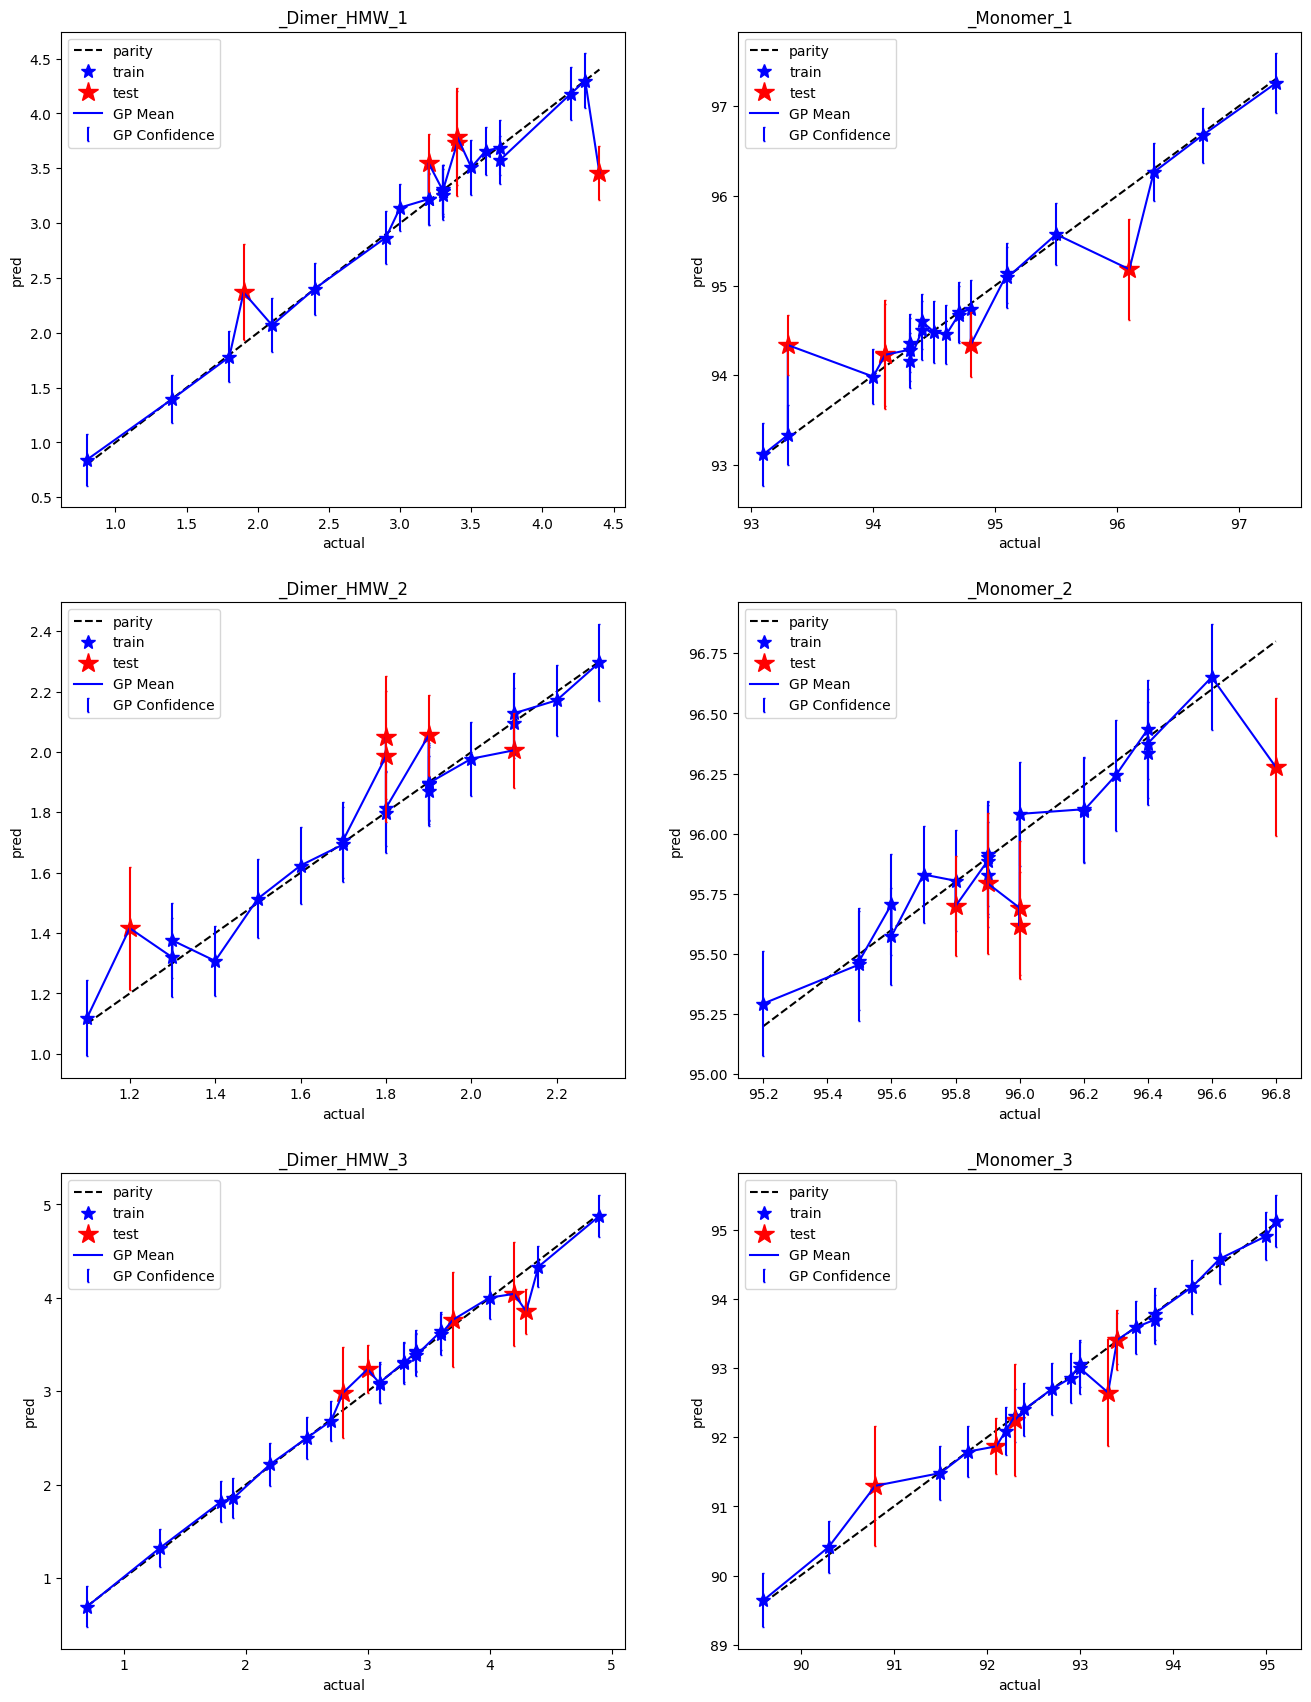

In [312]:
from sklearn.metrics import mean_squared_error

uncertainty_figure_option = 'errorbar' #shade or errorbar
is_set_axis_limit = False
cols_target_new = ['_Dimer_HMW_1', '_Monomer_1',
       '_Dimer_HMW_2', '_Monomer_2', 
       '_Dimer_HMW_3','_Monomer_3']

plot_axis_lb = total_df_y_long.min(axis = 0) - 0.4 * total_df_y_long.std(axis = 0)
plot_axis_ub = total_df_y_long.max(axis = 0) + 0.4 * total_df_y_long.std(axis = 0)

#num_outputs = arr_train_y.shape[-1]
#num_tasks = len(np.unique(arr_train_x[..., -1]))
num_outputs = len(cols_target)
num_tasks = 3

num_total_output = num_outputs*num_tasks
arr_train_metrics = np.zeros((11,num_total_output))
arr_test_metrics = np.zeros((11,num_total_output))

# Initialize plots
#f, y_axes = plt.subplots(num_tasks, num_outputs, figsize=(16, 48))
f, y_axes = plt.subplots(num_tasks, num_outputs, figsize=(num_outputs*8, num_tasks*7))
y_axes = y_axes.ravel()
for task_ind in range(num_tasks):
  for j,_ in enumerate(cols_target):
    a = j + len(cols_target)*task_ind
    tmp_col_y = cols_target_new[a]

    r_train_y = arr_train_y[:,a]
    r_train_mean_y =arr_train_mean[:,a]
    r_train_lower_y =arr_train_lower[:,a]
    r_train_upper_y =arr_train_upper[:,a]
    r_train_std = r_train_mean_y - r_train_lower_y

    r_test_y = arr_test_y[:,a]
    r_test_mean_y =arr_test_mean[:,a]
    r_test_lower_y =arr_test_lower[:,a]
    r_test_upper_y =arr_test_upper[:,a]
    r_test_std = r_test_mean_y - r_test_lower_y
    
    train_comp = np.concatenate((r_train_y.reshape(-1,1),r_train_mean_y.reshape(-1,1)),axis = 1)
    df_train_comp = pd.DataFrame(train_comp,columns = ['true','pred'])
    df_train_comp['upper'] = r_train_upper_y
    df_train_comp['lower'] = r_train_lower_y
    df_train_comp['mode'] = 'train'
    
    test_comp = np.concatenate((r_test_y.reshape(-1,1),r_test_mean_y.reshape(-1,1)),axis = 1)
    df_test_comp = pd.DataFrame(test_comp,columns = ['true','pred'])
    df_test_comp['upper'] = r_test_upper_y
    df_test_comp['lower'] = r_test_lower_y
    df_test_comp['mode'] = 'test'
    
    df_comp = pd.concat([df_train_comp,df_test_comp])
    df_comp_sorted = df_comp.sort_values(by = ['true'],ascending=True)

    #plot a parity line
    y_axes[a].plot(df_comp_sorted['true'], df_comp_sorted['true'], '--',c = 'black')
    
    # Plot training data as blue stars
    y_axes[a].plot(df_train_comp['true'], df_train_comp['pred'], 'k*',c = 'blue',markersize=10)

    # Plot training data as red stars
    y_axes[a].plot(df_test_comp['true'], df_test_comp['pred'], 'k*',c = 'red',markersize=15)
    # Predictive mean as blue line
    y_axes[a].plot(df_comp_sorted['true'], df_comp_sorted['pred'],c = 'blue')
    
    if uncertainty_figure_option == 'shade':
    # Shade in confidence
      y_axes[a].fill_between(x = df_comp_sorted['true'],y1 = df_comp_sorted['lower'], y2 = df_comp_sorted['upper'], color='b', alpha=.15)
    else:
      yerr = df_comp_sorted['pred'] - df_comp_sorted['lower']
      yerr = yerr.values.tolist()
      #y_axes[a].errorbar(x = df_comp_sorted['true'], y = df_comp_sorted['pred'], yerr = yerr, capsize=1, fmt='none', ecolor = 'black')
      yerr_train = df_train_comp['pred'] - df_train_comp['lower']
      yerr_train = yerr_train.values.tolist()
      yerr_test = df_test_comp['pred'] - df_test_comp['lower']
      yerr_test = yerr_test.values.tolist()
      y_axes[a].errorbar(x = df_train_comp['true'], y = df_train_comp['pred'], yerr = yerr_train, capsize=1, fmt='none', ecolor = 'blue')
      y_axes[a].errorbar(x = df_test_comp['true'], y = df_test_comp['pred'], yerr = yerr_test, capsize=1, fmt='none', ecolor = 'red')
    
    if is_set_axis_limit:
      y_axes[a].set_xlim([plot_axis_lb[j],plot_axis_ub[j]])
      y_axes[a].set_ylim([plot_axis_lb[j],plot_axis_ub[j]])

    y_axes[a].legend(['parity','train','test','GP Mean','GP Confidence'])
    y_axes[a].set_title(tmp_col_y)
    y_axes[a].set_xlabel('actual')
    y_axes[a].set_ylabel('pred')

    y_true = r_test_y
    y_pred = r_test_mean_y
    y_train = r_train_y
    mean_train = r_train_mean_y
    

    arr_test_metrics[0,a] = np.round(metrics.mean_absolute_error(y_true, y_pred),2)
    arr_test_metrics[1,a] = np.round(metrics.median_absolute_error(y_true, y_pred),2)
    arr_test_metrics[2,a] = np.round(metrics.mean_squared_error(y_true, y_pred),2)
    arr_test_metrics[3,a] = round(metrics.mean_squared_error(y_true, y_pred),2)
    arr_test_metrics[4,a] = round(metrics.mean_absolute_percentage_error(y_true, y_pred),2)
    arr_test_metrics[5,a] = round(metrics.max_error(y_true, y_pred),2)
    arr_test_metrics[6,a] = round(metrics.explained_variance_score(y_true, y_pred),2)
    arr_test_metrics[7,a] = round(metrics.r2_score(y_true, y_pred),2)
    arr_test_metrics[8,a] = round(np.mean(r_test_std),2)
    arr_test_metrics[9,a] = round(np.min(r_test_std),2)
    arr_test_metrics[10,a] = round(np.max(r_test_std),2)

    arr_train_metrics[0,a] = round(metrics.mean_absolute_error(y_train, mean_train),2)
    arr_train_metrics[1,a] = round(metrics.median_absolute_error(y_train, mean_train),2)
    arr_train_metrics[2,a] = round(metrics.mean_squared_error(y_train, mean_train),2)
    arr_train_metrics[3,a] = round(metrics.mean_squared_error(y_train, mean_train),2)
    arr_train_metrics[4,a] = round(metrics.mean_absolute_percentage_error(y_train, mean_train),2)
    arr_train_metrics[5,a] = round(metrics.max_error(y_train, mean_train),2)
    arr_train_metrics[6,a] = round(metrics.explained_variance_score(y_train, mean_train),2)
    arr_train_metrics[7,a] = round(metrics.r2_score(y_train, mean_train),2)
    arr_train_metrics[8,a] = round(np.mean(r_train_std),2)
    arr_train_metrics[9,a] = round(np.min(r_train_std),2)
    arr_train_metrics[10,a] = round(np.max(r_train_std),2)
    #arr_train_metrics[11,i] = my_gpr.kernel_.get_params()['k1__constant_value']
    #arr_train_metrics[12,i] = my_gpr.kernel_.get_params()['k2__length_scale']


if uncertainty_figure_option == 'shade' and is_set_axis_limit:
  plt.savefig(figPath+'/true-pred-shade.jpg')
elif uncertainty_figure_option == 'shade' and ~is_set_axis_limit:
  plt.savefig(figPath+'/true-pred-shade-zoomin.jpg')
elif uncertainty_figure_option == 'errorbar' and is_set_axis_limit:
  plt.savefig(figPath+'/true-pred-errorbar.jpg')
elif uncertainty_figure_option == 'errorbar' and ~is_set_axis_limit:
  plt.savefig(figPath+'/true-pred-errorbar-zoomin.jpg')

df_test_metrics = pd.DataFrame(arr_test_metrics,columns = cols_target_new, 
                               index = ['MAE','MAE2','MSE','RMSE','MAPE','MAXE','EVS','R2','AVG_STD','MIN_STD','MAX_STD'])
print(df_test_metrics)

df_train_metrics = pd.DataFrame(arr_train_metrics,columns = cols_target_new, 
                               index = ['MAE','MAE2','MSE','RMSE','MAPE','MAXE','EVS','R2','AVG_STD','MIN_STD','MAX_STD'])
print(df_train_metrics)


df_train_metrics.to_csv(figPath+'/df_train_metrics.csv')
df_test_metrics.to_csv(figPath+'/df_test_metrics.csv')

In [257]:
labels = [0,1, 2]
df_y_train_label = df_y_train.copy()
for tmp_col in df_y_train.columns:
    df_y_train_label[tmp_col+'_label'] = pd.cut(df_y_train[tmp_col], bins=len(labels), labels=labels)


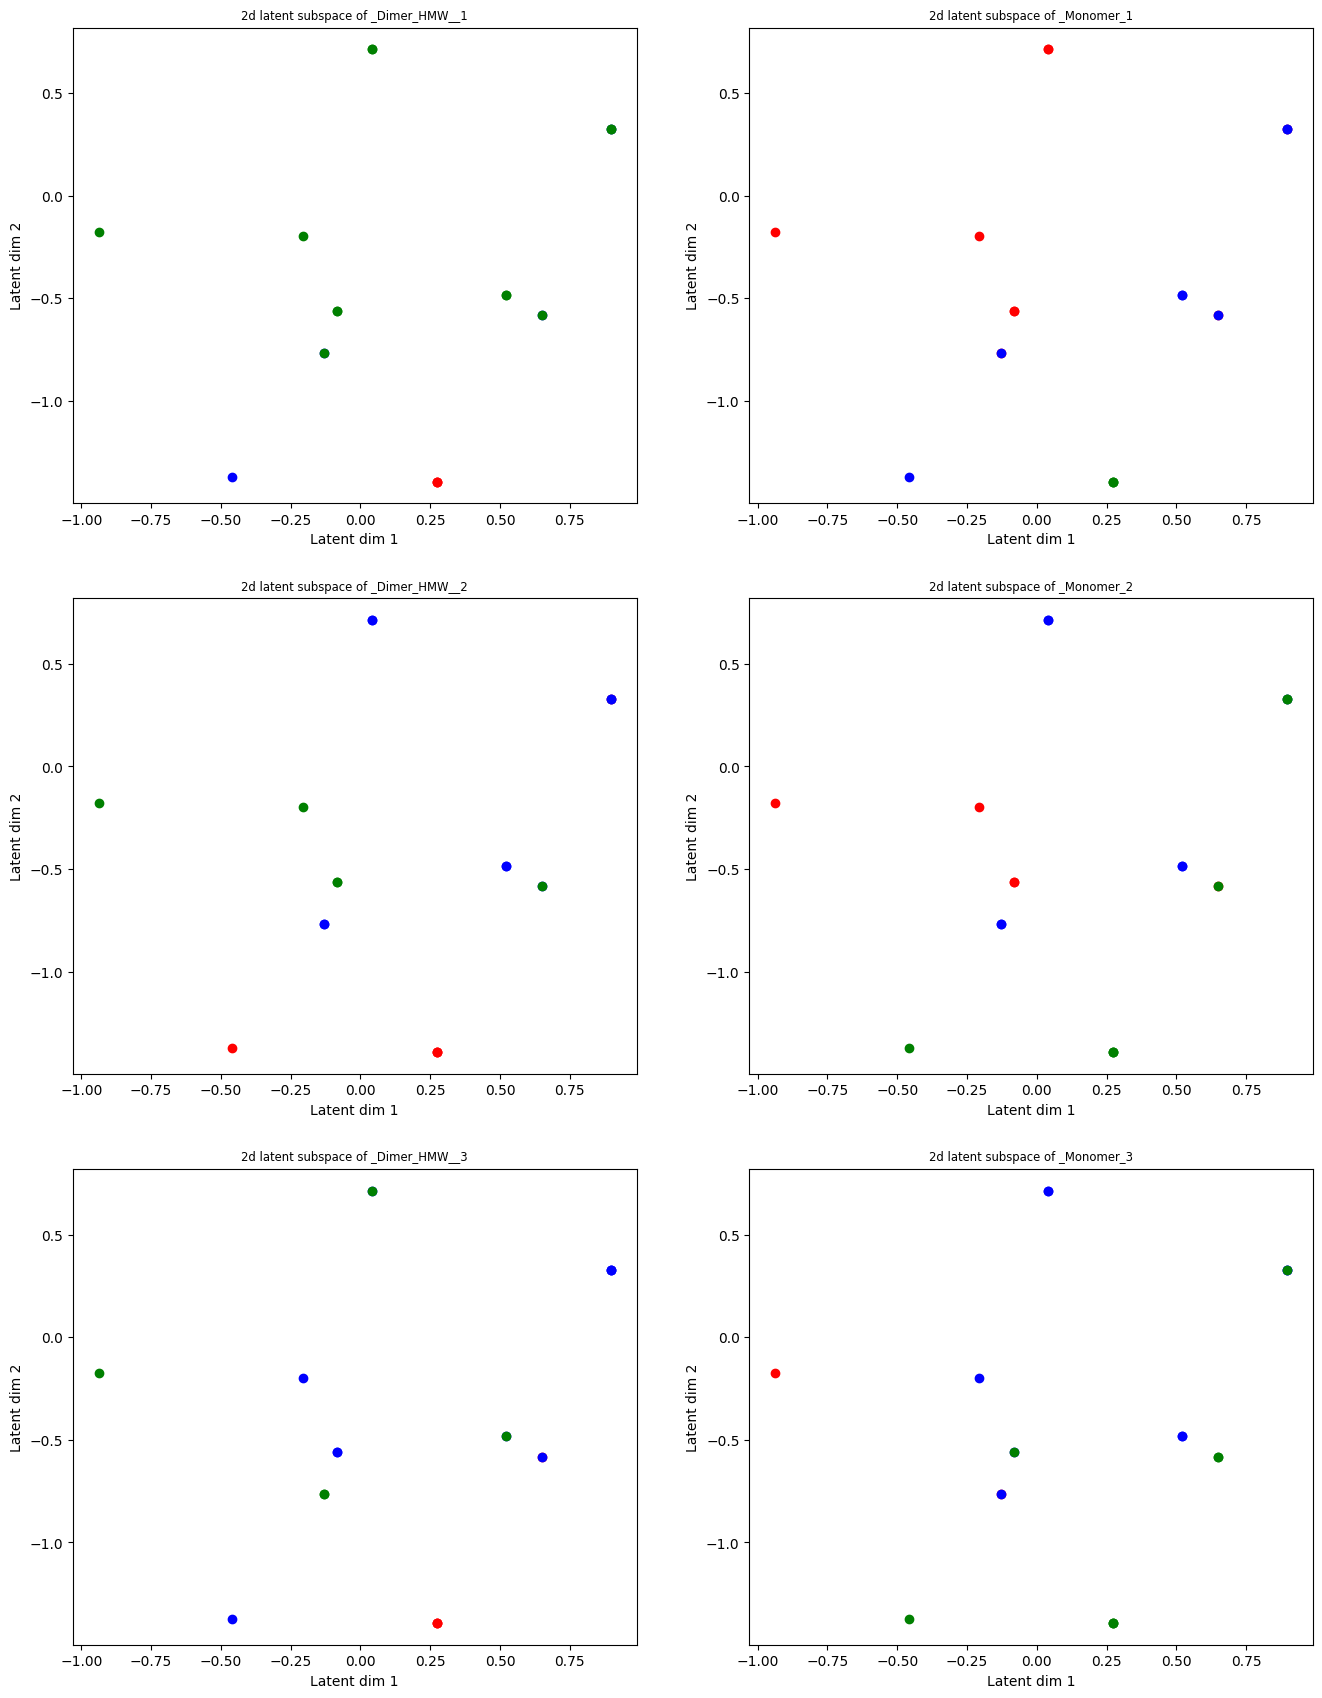

In [258]:
## visualizing the latent space
colors = ['r', 'b', 'g']
X = x_train_cate_latent.numpy()

f, y_axes = plt.subplots(num_tasks, num_outputs, figsize=(num_outputs*8, num_tasks*7))
y_axes = y_axes.ravel()
for task_ind in range(num_tasks):
  for j,_ in enumerate(cols_target):
    a = j + len(cols_target)*task_ind
    tmp_col_y = df_y_train.columns[a]

    # Select index of the smallest lengthscales by examining model.covar_module.base_kernel.lengthscales
    for i, label in enumerate(labels):
        X_i = X[df_y_train_label[tmp_col_y+'_label'] == label]
        y_axes[a].scatter(X_i[:, 0], X_i[:, 1], c=[colors[i]], label=label)

    y_axes[a].set_title('2d latent subspace of ' + tmp_col_y, fontsize='small')
    y_axes[a].set_xlabel('Latent dim 1')
    y_axes[a].set_ylabel('Latent dim 2')

In [227]:
#3d plot
from mpl_toolkits import mplot3d

def my_get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)


NUM_COLORS = num_tasks
cmap = my_get_cmap(NUM_COLORS)


#cm = plt.get_cmap('gist_rainbow')
ls_color = ['red','blue','green','orange']
colors = dict()
for i in range(NUM_COLORS):
    colors[i] = ls_color[i]
    #colors[p] = cmap(i)
    #colors[p] = cm(1.*i/NUM_COLORS)

/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_42174/94003429.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  return plt.cm.get_cmap(name, n)


In [249]:
df_X_train_with_lv= df_X_train.copy()
df_X_train_with_lv['lv1'] = X[:,0]
df_X_train_with_lv['lv2'] = X[:,1]

split_label = 'mix'

if split_label == 'mix':
    ls_X = [df_X_train_with_lv.copy(),
            df_X_train_with_lv.copy(),
            df_X_train_with_lv.copy()]
    
    for i,df_x in enumerate(ls_X):
        df_x['task_ind'] = i

    df_X_train_with_lv_long = pd.concat(ls_X)
    df_X_train_with_lv_long.reset_index(inplace=True, drop = True)

#df_X_train_with_lv_long.head()

In [254]:
arr_Y_train_long = np.concatenate((df_y_train.to_numpy()[:,:2],
                            df_y_train.to_numpy()[:,2:4],
                            df_y_train.to_numpy()[:,4:]),axis = 0)
df_Y_train_long = pd.DataFrame(arr_Y_train_long,columns= cols_target)

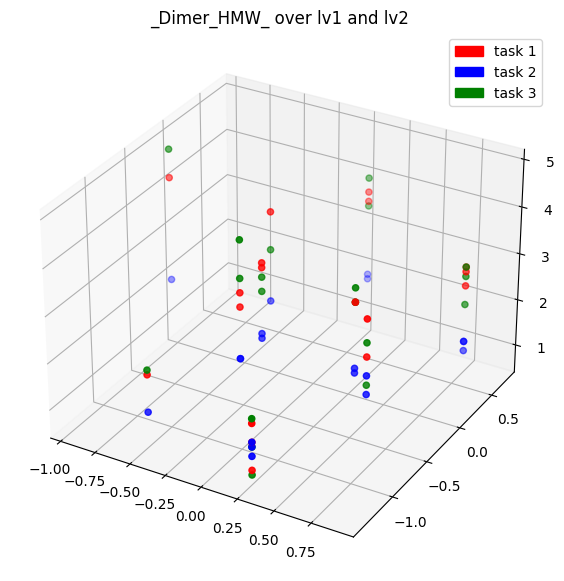

In [256]:

import matplotlib.patches as mpatches 

# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

x_name = 'lv1'
y_name = 'lv2'
z_name = cols_target[0]

# Creating plot

ax.scatter3D(df_X_train_with_lv_long[x_name], df_X_train_with_lv_long[y_name], 
             df_Y_train_long[z_name],c=df_X_train_with_lv_long['task_ind'].map(colors))
#
plt.title(f'{z_name} over {x_name} and {y_name}')
# Creating legend with color box 
pop_a = mpatches.Patch(label='task 1', color=colors[0]) 
pop_b = mpatches.Patch(label='task 2', color=colors[1])
pop_c = mpatches.Patch(label='task 3', color=colors[2])

plt.legend(handles=[pop_a,pop_b,pop_c]) 

# show plot
plt.show()